#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 3 - Deep Reinforcement Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving reinforcement learning problems. The basic tasks for the homework will require to implement some extensions to the code that you have seen in the Lab. More advanced tasks will require to train and test your learning agent on a different environment. Given the higher computational complexity of RL, in this homework you don’t need to tune learning hyperparameters using search procedures and cross-validation; however, you are encouraged to play with model hyperparameters in order to find a satisfactory configuration.


## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.

As an example of more advanced libraries that can be used to implement deep RL agents, you can check this website:

https://stable-baselines.readthedocs.io/en/master/



## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). Given the dynamical nature of RL problems, you can explore more sophisticated media for showing the results of your model (e.g., animated GIFs or short movies).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	3 pt: extend the notebook used in Lab 07, in order to learn to control the CartPole environment using directly the screen pixels, rather than the compact state representation used during the Lab (cart position, cart velocity, pole angle, pole angular velocity). This will require to change the “observation_space”.


## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

In [1]:
import random
import torch
import numpy as np
import gym
import cv2
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from PIL import Image
from IPython.display import clear_output
import optuna
from optuna.trial import TrialState

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

In [2]:
#enable virtual rendering
import gc
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [5]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
    mp4list = glob.glob('video/*.mp4')
    mp4list.sort()
    for mp4 in mp4list:
        print(f"\nSHOWING VIDEO {mp4}")
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, folder , video_callable=None):
    env = Monitor(env, './'+folder+'_video', force=True, video_callable=video_callable)
    return env

"*To perform experience replay, we store the agent's experiences e_t=(s_t,a_t,r_t,s_t+1) at each time-step t in a data set D_t={e_1,…,e_t}. During learning, we apply Q-learning updates, on samples (or mini-batches) of experience (s,a,r,s′)∼U(D), drawn uniformly at random from the pool of stored samples.*"

Source: https://www.nature.com/articles/nature14236

In practice, what we need is a queue with a predefined capacity. When we reach the maximum capacity, the oldest element in the queue will be replaced with the new one.

This exact behavior is implemented by the `deque` object from the python `collections` library (https://docs.python.org/3/library/collections.html#collections.deque):

"*If maxlen is not specified or is None, deques may grow to an arbitrary length. Otherwise, the deque is bounded to the specified maximum length. Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end.*"

The random sampling can be easily achieved using the `random.sample` method (https://docs.python.org/3/library/random.html).

In [6]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

# Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 64 neurons each). 

Be sure to keep a linear output activation.

## Exploration Policy

Starting from the estimated Q-values, we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy

With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [7]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state   = state.clone().detach() # Convert the state to tensor
        net_out = net(state).squeeze(0)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.


In [8]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state   = state.clone().detach()
        net_out = net(state).squeeze(0)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

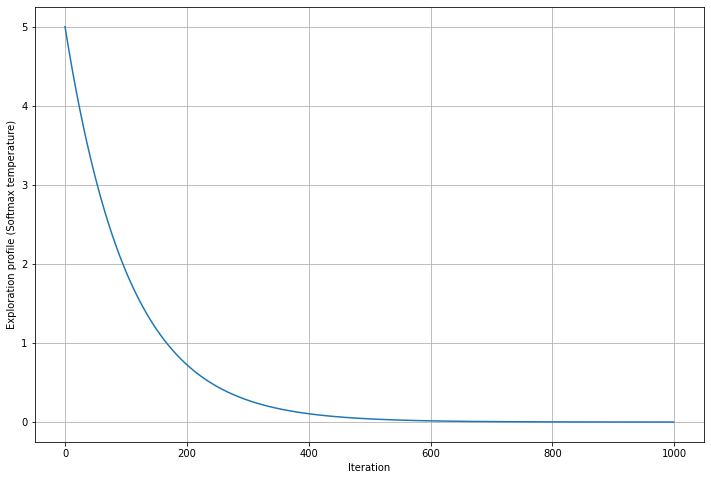

In [9]:
### Define exploration profile
initial_value = 5
#num_iterations = 1000
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

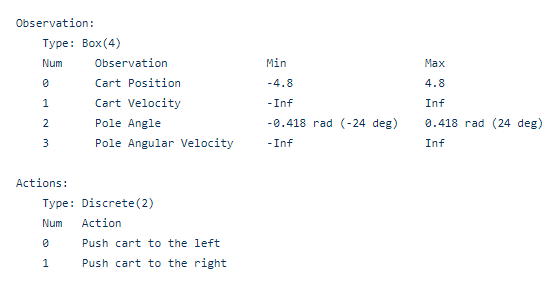

In [10]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim  = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


In [11]:
# Set random seeds
seed = 753
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [12]:
# convert to black and white, since we do not lose any important info, moreover 
# crop the figure to have only the cart in the picture and finally 
# rescale it preserving ratio between dimensions

#https://stackoverflow.com/questions/18777873/convert-rgb-to-black-or-white
def to_bw_rescale(env, scale_percent = 50):
    
    img       = env.render(mode='rgb_array')
    #convert to B/W
    img_rgb   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #crop the image vertically
    cart_upper = int(0.8 * img_rgb.shape[0])
    cart_lower = int(0.4 * img_rgb.shape[0])
    
    #crop the image horizontally
    scale_factor = img_rgb.shape[1]/(2*env.x_threshold)
    cart_pos   = int(env.state[0]*scale_factor + 0.5*img_rgb.shape[1]) 
    cart_left  = int(cart_pos - 40)
    cart_right = int(cart_pos + 40)
    
    if cart_left < 0:
        cart_left  = 0
        cart_right = 80
    elif cart_right > img_rgb.shape[1]:
        cart_left  = img_rgb.shape[1] - 80
        cart_right = img_rgb.shape[1]
    
    cropped    = img_rgb[cart_lower:cart_upper, cart_left:cart_right]
    cropped[cropped < 255] = 0
    cropped    = cropped / 255
    
    #rescale the dim of some percent
    #calculate the some percent of original dimensions with proper proportions
    width  = int(cropped.shape[1] * scale_percent / 100)
    height = int(cropped.shape[0] * scale_percent / 100)
    img_rgb_rescaled = cv2.resize(cropped, (width, height), interpolation = cv2.INTER_AREA )
    
    
    return img_rgb_rescaled

Size of the cropped image is:  (80, 40)


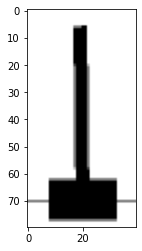

In [13]:
env = gym.make('CartPole-v1') 
env.seed(seed)
state = env.reset()
#get image as 50% of the initial one 
img = to_bw_rescale(env, 50)
plt.imshow(img, cmap='gist_gray')
print("Size of the cropped image is: ", img.shape)
plt.show()

In [14]:
def to_bw_crop(env, scale_percent = 50):
    #convert to black and white, since we do not lose any important info, moreover
    #crop the picture preserving only the "horizontal belt" to preserve visual info on the cart location
    
    img       = env.render(mode='rgb_array')
    #convert to B/W
    img_rgb   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #crop the image vertically
    cart_upper = int(0.8 * img_rgb.shape[0])
    cart_lower = int(0.4 * img_rgb.shape[0])
    cropped    = img_rgb[cart_lower:cart_upper, 0:img_rgb.shape[1]]

    #rescale the dim of some percent
    #calculate the some percent of original dimensions with proper proportions
    width  = int(cropped.shape[1] * scale_percent / 100)
    height = int(cropped.shape[0] * scale_percent / 100)
    img_rgb_rescaled = cv2.resize(cropped, (width, height), interpolation = cv2.INTER_AREA )
    img_rgb_rescaled[img_rgb_rescaled < 255] = 0
    img_rgb_rescaled = img_rgb_rescaled / 255
    
    return img_rgb_rescaled

Size of the cropped image is:  (160, 600)


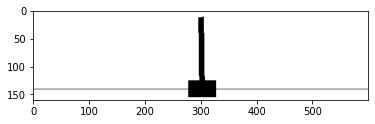

In [15]:
env = gym.make('CartPole-v1') 
env.seed(seed)
state = env.reset()
#get image as 50% of the initial one 
img = to_bw_crop(env, 100)
plt.imshow(img, cmap='gist_gray')
print("Size of the cropped image is: ", img.shape)
plt.show()

In [16]:
def to_bw(env):
    #simply convert the picture to BW
    
    img       = env.render(mode='rgb_array')
    #convert to B/W
    img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img[img < 255] = 0
    img = img / 255
    
    return img

Size of the cropped image is:  (400, 600)


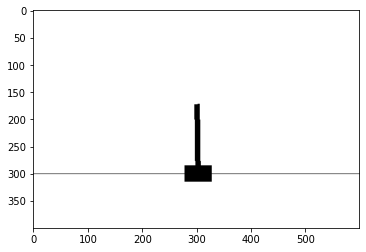

In [17]:
env = gym.make('CartPole-v1') 
env.seed(seed)
state = env.reset()
#get image as 50% of the initial one 
img = to_bw(env)
plt.imshow(img, cmap='gist_gray')
print("Size of the cropped image is: ", img.shape)
plt.show()

In [18]:
def convert_frame_to_tensor(frame):
    return torch.tensor(frame).type(torch.float).unsqueeze(0)

### Network definition

In [19]:
class DQCNN(nn.Module):
    def __init__(self, n_frames, input_shape : tuple, action_space_dim = 2, inter_channels = 8):
        super().__init__()
        
        kernel1 = 8
        stride1 = 4
        
        kernel2 = 4
        stride2 = 2
        
        self.input_shape = input_shape
        self.CNN = nn.Sequential(
                
                nn.Conv2d(in_channels  = n_frames,
                          out_channels = n_frames*inter_channels,
                          kernel_size  = kernel1,
                          stride       = stride1),
                nn.ReLU(),
            
                nn.Conv2d(in_channels  = n_frames*inter_channels,  
                          out_channels = 2*n_frames*inter_channels,
                          kernel_size  = kernel2,
                          stride       = stride2
                         ),
                nn.ReLU(),
                ### Unflatten
                nn.Flatten(start_dim=1),
                )
        
        #compute authomatically the resulting dimensions fr the elaborated picture
        width_out1  = self.conv2d_size_out(input_shape[1], kernel1, stride1)
        height_out1 = self.conv2d_size_out(input_shape[0], kernel1, stride1)
        width_out2  = self.conv2d_size_out(width_out1,  kernel2, stride2)
        height_out2 = self.conv2d_size_out(height_out1, kernel2, stride2)
        self.unflatten_dim = (2*n_frames*inter_channels)*(width_out2*height_out2)
        
        self.linear = nn.Sequential(
                nn.Linear(self.unflatten_dim, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, action_space_dim)
                )
        return
    
    def conv2d_size_out(self, size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
    
    def forward(self, x):
        x = self.CNN(x)
        x = self.linear(x)
        return x
        

In [20]:
# Define an example network
net = DQCNN(n_frames = 4, input_shape = img.shape, inter_channels = 4)
net

DQCNN(
  (CNN): Sequential(
    (0): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=112128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [21]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
# env = wrap_env(env, video_callable=lambda episode_id: True)
img_list = []
# Let's try for a total of 10 episodes
for num_episode in range(10):
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done  = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
        # Choose a random action
        action = random.choice([0, 1])
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        img_list.append(to_bw_rescale(env))
      # Visually render the environment (optional, comment this line to speed up the simulation)
#       env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: 84.0
EPISODE 2 - FINAL SCORE: 12.0
EPISODE 3 - FINAL SCORE: 18.0
EPISODE 4 - FINAL SCORE: 69.0
EPISODE 5 - FINAL SCORE: 18.0
EPISODE 6 - FINAL SCORE: 14.0
EPISODE 7 - FINAL SCORE: 43.0
EPISODE 8 - FINAL SCORE: 21.0
EPISODE 9 - FINAL SCORE: 35.0
EPISODE 10 - FINAL SCORE: 13.0


# Network update

## Initialization

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [22]:
# Set random seeds
seed = 753
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 2000   # Replay memory capacity
lr = 1e-3   # Optimizer learning rate
target_net_update_steps = 5   # Number of episodes to wait before updating the target network
batch_size = 16   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 200   # Minimum samples in the replay memory to enable the training

In [23]:
def initialize_networks(n_frames = 1, input_shape = (400,600), action_space_dim = 2, replay_memory_capacity = replay_memory_capacity, inter_channels = 8):

    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQCNN(n_frames, inter_channels = inter_channels, input_shape = input_shape)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQCNN(n_frames, inter_channels = inter_channels, input_shape = input_shape)
    
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [24]:
def zero_to_epsilon(value, epsilon = 1e-5):
    if value < epsilon:
        return epsilon
    else:
        return value

def below_threshold_to_fixed(value, threshold = 0.1):
    if value < threshold:
        return threshold
    else:
        return value
    
class exploration_profile():
    def __init__(self, explor_type, initial_temp, num_iterations, threshold = 0.2):
        '''
        Explor type can take 3 different values:
        - 0 linear decay that goes to zero
        - 1 linear decay that goes up to a threshold
        - 2 exponential decay
        '''
        self.length  = num_iterations
        self.initial = initial_temp
        self.where = []
        
        if explor_type == 0:
            n_steps = int(num_iterations/4)
            delta   = initial_temp/n_steps
            self.profile =  [zero_to_epsilon(initial_temp - i*delta - 1e-6 ) for i in range(num_iterations)]
        if explor_type == 1:
            n_steps = int(num_iterations/4)
            delta   = initial_temp/n_steps
            self.profile =  [below_threshold_to_fixed(initial_temp - i*delta - 1e-6 , threshold) for i in range(num_iterations)]
        if explor_type == 2:
            if initial_temp == 1:
                initial_temp = 2
                decay = np.exp(-np.log(initial_temp) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
                self.profile = np.array([initial_temp * (decay ** i) for i in range(num_iterations)])
                self.profile = self.profile/2 - 1e-6
            else:
                decay = np.exp(-np.log(initial_temp) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
                self.profile = [initial_temp * (decay ** i) for i in range(num_iterations)]
                
        return 
    
    def get_profile(self):
        return np.array(self.profile)
    
    def add_noise(self, mean = 0., sigma = 1., ampl = 1.):
        if (mean == 0.):
            mean  = np.random.randint(1 , self.length)
        sigma = self.length/50
        ampl  = self.initial*5
        self.where.append((mean, sigma))
        
        noise = np.array([ampl * np.exp(-0.5 * (i - mean)**2/sigma**2) / (sigma * np.sqrt(2*np.pi)) for i in range(self.length)])
        self.profile += noise
        return 
    
    def plot_profile(self):
        plt.plot(self.profile)
        plt.xlabel("Episode")
        plt.ylabel("Temperature")
        plt.show()
        return
    
    def get_where_noise(self):
        return self.where

In [25]:
def preprocess_frame(env, type_preproc, scale = 50):
    if type_preproc == 0:
        img = to_bw(env)
    if type_preproc == 1:
        img = to_bw_crop(env, scale_percent = scale)
    if type_preproc == 2:
        img = to_bw_rescale(env, scale_percent = scale)
    return img

## Update function

In [26]:
def update_step(policy_net, target_net, gamma, replay_mem, optimizer, loss_fn, batch_size):
                
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)
    
    # Create tensors for each element of the batch
    states  = torch.tensor([s[0] for s in batch], dtype=torch.float32).clone().detach()
    actions = torch.tensor([s[1] for s in batch], dtype=torch.int64).clone().detach()
    rewards = torch.tensor([s[3] for s in batch], dtype=torch.float32).clone().detach()

    # Compute a mask of non-final states 
    # (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32).clone().detach() 
    
    # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool).clone().detach()

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states.to(device)).cpu()
    
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states.to(device)).cpu()
    
    next_state_max_q_values = torch.zeros(batch_size).clone().detach()
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].clone().detach()

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    # Set the required tensor shape
    expected_state_action_values = expected_state_action_values.unsqueeze(1) 

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()
    
    gc.collect()

## Training loop

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(seed+1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, folder = 'pixel' , video_callable=lambda episode_id: True) # Save a video every episode
env.reset()

type_preproc = 2
scale        = 50
n_frames     = 3
update_type  = 'softmax' 

frame = preprocess_frame(env, type_preproc, scale)

frame_history = deque(maxlen=n_frames)
for i in range(n_frames): 
    frame_history.append(np.zeros((1, frame.shape[0], frame.shape[1])))
    
scores = []

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    frame = preprocess_frame(env, type_preproc, scale)[np.newaxis, :]
    
    for i in range(n_frames):
        frame = np.append( frame , frame_history[-i-1], axis=0)
   
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        for i in range(n_frames):
            if frame_history[i] is None: 
                frame_history[i] = np.zeros((1, frame.shape[0], frame.shape[1]))

        frame_history.append(frame[0][np.newaxis, :])
        # Choose the action following the policy
        if update_type == 'softmax':
            action, q_values = choose_action_softmax(net5, convert_frame_to_tensor(frame), temperature=0)
        elif update_type == 'greedy': 
            action, q_values = choose_action_epsilon_greedy(net5, convert_frame_to_tensor(frame), 0)
        else:
            print("Not valid update rule")
            break
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        next_frame = preprocess_frame(env, type_preproc, scale)[np.newaxis, :]
        for i in range(n_frames):
            next_frame = np.append( next_frame, frame_history[-i-1], axis=0) 
        # Visually render the environment
        env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        frame = next_frame
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    scores.append(score)
    
env.close() 

print("Max score obtained is \t \t:", max(scores))

In [27]:
def training(explor_profile, n_frames : int, update_type : str,  preproc : tuple, inter_channels  = 4, optuna_flag = False):
    
    env = gym.make('CartPole-v1') 
    env.seed(seed)
    env.reset()
    
    type_preproc = preproc[0]
    scale        = preproc[1]

    frame        = preprocess_frame(env, type_preproc, scale)
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialize_networks(n_frames       = n_frames + 1,
                                                                                 inter_channels = inter_channels,
                                                                                 input_shape    = frame.shape)
    score_list = []
    frame_history = deque(maxlen=n_frames)

    for i in range(n_frames): 
        frame_history.append(np.zeros((1, frame.shape[0], frame.shape[1]) ))

    for episode_num, tau in enumerate(tqdm(explor_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        frame = preprocess_frame(env, type_preproc, scale)[np.newaxis, :]

        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False
        # Go on until the pole falls off
        for i in range(n_frames):
            frame = np.append( frame, frame_history[-i-1], axis=0)

        while not done:
            # Adding history
            for i in range(n_frames):
                if frame_history[i] is None: 
                    frame_history[i] = np.zeros((1, frame.shape[0], frame.shape[1]))

            frame_history.append(frame[0][np.newaxis, :])
            
            # Choose the action following the policy
            if update_type == 'softmax':
                action, q_values = choose_action_softmax(policy_net, convert_frame_to_tensor(frame), temperature=tau)
            elif update_type == 'greedy': 
                action, q_values = choose_action_epsilon_greedy(policy_net, convert_frame_to_tensor(frame), tau)
            else:
                print("Not valid update rule")
                break

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)
            next_frame = preprocess_frame(env, type_preproc, scale)[np.newaxis, :]

                
            # update frame history 
            for i in range(n_frames):
                next_frame = np.append( next_frame, frame_history[-i-1], axis = 0) 

            # Reward penalty when the cart is far from the centre
            off_cen_penalty = 1.
            reward = reward - off_cen_penalty * np.abs(state[0])

            # Update the final score (+1 for each step)
            score += 1
            
            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward    += bad_state_penalty
                next_state = None
                next_frame = None

            # Update the replay memory
            replay_mem.push(frame, action, next_frame, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, gamma, replay_mem, optimizer, loss_fn, batch_size)

            # Set the current state for the next iteration
            frame = next_frame
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % target_net_update_steps == 0:
    #         print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score only if not doing hyperparams optimization
        if optuna_flag == False:
            print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        score_list.append(score)

    env.close()
    
    return np.array(score_list), policy_net

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_results(results, profile, nframes, type_update):
    best_max_temp = profile[0]
    scale = max(results)//best_max_temp

    fig, ax = plt.subplots(1,2, figsize = (15,5), sharey = True)
    ax[0].plot(scale*profile,  label = str(scale)+'*Temperature')
    ax[0].plot(np.array(results), label = 'Score')
    ax[0].legend()
    ax[0].set_xlabel("Episode")

    ax[1].plot(moving_average(results, 100), label = "Average score")
    ax[1].legend()
    ax[1].set_title("Rolling Average Score")
    ax[1].set_xlabel("Episode")
    ax[1].set_ylabel("Score")

    plt.suptitle(str("Using "+ str(nframes) + " consecutive frames and " + str(type_update) +" update rule"), fontsize = 15)
    plt.show()
    return

Different exploration landscapes that might be taken into account.

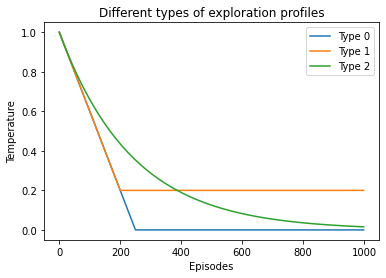

In [28]:
my_profile0 = exploration_profile(explor_type = 0, initial_temp = 4 , num_iterations = 1000).get_profile()
my_profile1 = exploration_profile(explor_type = 1, initial_temp = 4 , num_iterations = 1000).get_profile()
my_profile2 = exploration_profile(explor_type = 2, initial_temp = 4 , num_iterations = 1000).get_profile()

plt.plot(my_profile0, label = "Type 0")
plt.plot(my_profile1, label = "Type 1")
plt.plot(my_profile2, label = "Type 2")
plt.title("Different types of exploration profiles")
plt.xlabel("Episodes")
plt.ylabel("Temperature")
plt.legend()
plt.show()

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 3.999999
EPISODE: 2 - FINAL SCORE: 16 - Temperature: 3.983999
EPISODE: 3 - FINAL SCORE: 14 - Temperature: 3.967999
EPISODE: 4 - FINAL SCORE: 15 - Temperature: 3.951999
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 3.935999
EPISODE: 6 - FINAL SCORE: 14 - Temperature: 3.919999
EPISODE: 7 - FINAL SCORE: 22 - Temperature: 3.9039989999999998
EPISODE: 8 - FINAL SCORE: 63 - Temperature: 3.8879989999999998
EPISODE: 9 - FINAL SCORE: 33 - Temperature: 3.8719989999999997
EPISODE: 10 - FINAL SCORE: 36 - Temperature: 3.8559989999999997
EPISODE: 11 - FINAL SCORE: 26 - Temperature: 3.8399989999999997
EPISODE: 12 - FINAL SCORE: 17 - Temperature: 3.8239989999999997
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 3.8079989999999997
EPISODE: 14 - FINAL SCORE: 57 - Temperature: 3.7919989999999997
EPISODE: 15 - FINAL SCORE: 13 - Temperature: 3.7759989999999997
EPISODE: 16 - FINAL SCORE: 16 - Temperature: 3.7599989999999996
EPISODE: 17 - FINAL SCORE: 21 - Temperature: 

EPISODE: 144 - FINAL SCORE: 21 - Temperature: 1.7119989999999998
EPISODE: 145 - FINAL SCORE: 14 - Temperature: 1.6959989999999998
EPISODE: 146 - FINAL SCORE: 34 - Temperature: 1.6799990000000002
EPISODE: 147 - FINAL SCORE: 10 - Temperature: 1.6639990000000002
EPISODE: 148 - FINAL SCORE: 11 - Temperature: 1.6479990000000002
EPISODE: 149 - FINAL SCORE: 19 - Temperature: 1.6319990000000002
EPISODE: 150 - FINAL SCORE: 29 - Temperature: 1.6159990000000002
EPISODE: 151 - FINAL SCORE: 22 - Temperature: 1.5999990000000002
EPISODE: 152 - FINAL SCORE: 13 - Temperature: 1.5839990000000002
EPISODE: 153 - FINAL SCORE: 16 - Temperature: 1.5679990000000001
EPISODE: 154 - FINAL SCORE: 23 - Temperature: 1.5519990000000001
EPISODE: 155 - FINAL SCORE: 14 - Temperature: 1.5359990000000001
EPISODE: 156 - FINAL SCORE: 13 - Temperature: 1.519999
EPISODE: 157 - FINAL SCORE: 45 - Temperature: 1.503999
EPISODE: 158 - FINAL SCORE: 14 - Temperature: 1.487999
EPISODE: 159 - FINAL SCORE: 10 - Temperature: 1.471999


EPISODE: 286 - FINAL SCORE: 10 - Temperature: 0.2
EPISODE: 287 - FINAL SCORE: 44 - Temperature: 0.2
EPISODE: 288 - FINAL SCORE: 17 - Temperature: 0.2
EPISODE: 289 - FINAL SCORE: 12 - Temperature: 0.2
EPISODE: 290 - FINAL SCORE: 11 - Temperature: 0.2
EPISODE: 291 - FINAL SCORE: 10 - Temperature: 0.2
EPISODE: 292 - FINAL SCORE: 11 - Temperature: 0.2
EPISODE: 293 - FINAL SCORE: 10 - Temperature: 0.2
EPISODE: 294 - FINAL SCORE: 11 - Temperature: 0.2
EPISODE: 295 - FINAL SCORE: 16 - Temperature: 0.2
EPISODE: 296 - FINAL SCORE: 19 - Temperature: 0.2
EPISODE: 297 - FINAL SCORE: 9 - Temperature: 0.2
EPISODE: 298 - FINAL SCORE: 9 - Temperature: 0.2
EPISODE: 299 - FINAL SCORE: 10 - Temperature: 0.2
EPISODE: 300 - FINAL SCORE: 8 - Temperature: 0.2
EPISODE: 301 - FINAL SCORE: 16 - Temperature: 0.2
EPISODE: 302 - FINAL SCORE: 11 - Temperature: 0.2
EPISODE: 303 - FINAL SCORE: 20 - Temperature: 0.2
EPISODE: 304 - FINAL SCORE: 9 - Temperature: 0.2
EPISODE: 305 - FINAL SCORE: 8 - Temperature: 0.2
EPISO

EPISODE: 451 - FINAL SCORE: 56 - Temperature: 0.2
EPISODE: 452 - FINAL SCORE: 21 - Temperature: 0.2
EPISODE: 453 - FINAL SCORE: 39 - Temperature: 0.2
EPISODE: 454 - FINAL SCORE: 42 - Temperature: 0.2
EPISODE: 455 - FINAL SCORE: 55 - Temperature: 0.2
EPISODE: 456 - FINAL SCORE: 35 - Temperature: 0.2
EPISODE: 457 - FINAL SCORE: 36 - Temperature: 0.2
EPISODE: 458 - FINAL SCORE: 52 - Temperature: 0.2
EPISODE: 459 - FINAL SCORE: 26 - Temperature: 0.2
EPISODE: 460 - FINAL SCORE: 43 - Temperature: 0.2
EPISODE: 461 - FINAL SCORE: 37 - Temperature: 0.2
EPISODE: 462 - FINAL SCORE: 47 - Temperature: 0.2
EPISODE: 463 - FINAL SCORE: 27 - Temperature: 0.2
EPISODE: 464 - FINAL SCORE: 34 - Temperature: 0.2
EPISODE: 465 - FINAL SCORE: 32 - Temperature: 0.2
EPISODE: 466 - FINAL SCORE: 37 - Temperature: 0.2
EPISODE: 467 - FINAL SCORE: 27 - Temperature: 0.2
EPISODE: 468 - FINAL SCORE: 31 - Temperature: 0.2
EPISODE: 469 - FINAL SCORE: 25 - Temperature: 0.2
EPISODE: 470 - FINAL SCORE: 39 - Temperature: 0.2


EPISODE: 615 - FINAL SCORE: 38 - Temperature: 0.2
EPISODE: 616 - FINAL SCORE: 25 - Temperature: 0.2
EPISODE: 617 - FINAL SCORE: 48 - Temperature: 0.2
EPISODE: 618 - FINAL SCORE: 37 - Temperature: 0.2
EPISODE: 619 - FINAL SCORE: 13 - Temperature: 0.2
EPISODE: 620 - FINAL SCORE: 29 - Temperature: 0.2
EPISODE: 621 - FINAL SCORE: 25 - Temperature: 0.2
EPISODE: 622 - FINAL SCORE: 23 - Temperature: 0.2
EPISODE: 623 - FINAL SCORE: 17 - Temperature: 0.2
EPISODE: 624 - FINAL SCORE: 35 - Temperature: 0.2
EPISODE: 625 - FINAL SCORE: 36 - Temperature: 0.2
EPISODE: 626 - FINAL SCORE: 16 - Temperature: 0.2
EPISODE: 627 - FINAL SCORE: 43 - Temperature: 0.2
EPISODE: 628 - FINAL SCORE: 21 - Temperature: 0.2
EPISODE: 629 - FINAL SCORE: 13 - Temperature: 0.2
EPISODE: 630 - FINAL SCORE: 28 - Temperature: 0.2
EPISODE: 631 - FINAL SCORE: 11 - Temperature: 0.2
EPISODE: 632 - FINAL SCORE: 29 - Temperature: 0.2
EPISODE: 633 - FINAL SCORE: 67 - Temperature: 0.2
EPISODE: 634 - FINAL SCORE: 27 - Temperature: 0.2


EPISODE: 779 - FINAL SCORE: 33 - Temperature: 0.2
EPISODE: 780 - FINAL SCORE: 42 - Temperature: 0.2
EPISODE: 781 - FINAL SCORE: 37 - Temperature: 0.2
EPISODE: 782 - FINAL SCORE: 40 - Temperature: 0.2
EPISODE: 783 - FINAL SCORE: 41 - Temperature: 0.2
EPISODE: 784 - FINAL SCORE: 23 - Temperature: 0.2
EPISODE: 785 - FINAL SCORE: 39 - Temperature: 0.2
EPISODE: 786 - FINAL SCORE: 24 - Temperature: 0.2
EPISODE: 787 - FINAL SCORE: 32 - Temperature: 0.2
EPISODE: 788 - FINAL SCORE: 25 - Temperature: 0.2
EPISODE: 789 - FINAL SCORE: 40 - Temperature: 0.2
EPISODE: 790 - FINAL SCORE: 12 - Temperature: 0.2
EPISODE: 791 - FINAL SCORE: 14 - Temperature: 0.2
EPISODE: 792 - FINAL SCORE: 19 - Temperature: 0.2
EPISODE: 793 - FINAL SCORE: 31 - Temperature: 0.2
EPISODE: 794 - FINAL SCORE: 14 - Temperature: 0.2
EPISODE: 795 - FINAL SCORE: 26 - Temperature: 0.2
EPISODE: 796 - FINAL SCORE: 26 - Temperature: 0.2
EPISODE: 797 - FINAL SCORE: 85 - Temperature: 0.2
EPISODE: 798 - FINAL SCORE: 22 - Temperature: 0.2


EPISODE: 943 - FINAL SCORE: 11 - Temperature: 0.2
EPISODE: 944 - FINAL SCORE: 42 - Temperature: 0.2
EPISODE: 945 - FINAL SCORE: 21 - Temperature: 0.2
EPISODE: 946 - FINAL SCORE: 43 - Temperature: 0.2
EPISODE: 947 - FINAL SCORE: 34 - Temperature: 0.2
EPISODE: 948 - FINAL SCORE: 24 - Temperature: 0.2
EPISODE: 949 - FINAL SCORE: 36 - Temperature: 0.2
EPISODE: 950 - FINAL SCORE: 24 - Temperature: 0.2
EPISODE: 951 - FINAL SCORE: 42 - Temperature: 0.2
EPISODE: 952 - FINAL SCORE: 13 - Temperature: 0.2
EPISODE: 953 - FINAL SCORE: 32 - Temperature: 0.2
EPISODE: 954 - FINAL SCORE: 11 - Temperature: 0.2
EPISODE: 955 - FINAL SCORE: 37 - Temperature: 0.2
EPISODE: 956 - FINAL SCORE: 37 - Temperature: 0.2
EPISODE: 957 - FINAL SCORE: 31 - Temperature: 0.2
EPISODE: 958 - FINAL SCORE: 34 - Temperature: 0.2
EPISODE: 959 - FINAL SCORE: 68 - Temperature: 0.2
EPISODE: 960 - FINAL SCORE: 26 - Temperature: 0.2
EPISODE: 961 - FINAL SCORE: 13 - Temperature: 0.2
EPISODE: 962 - FINAL SCORE: 51 - Temperature: 0.2


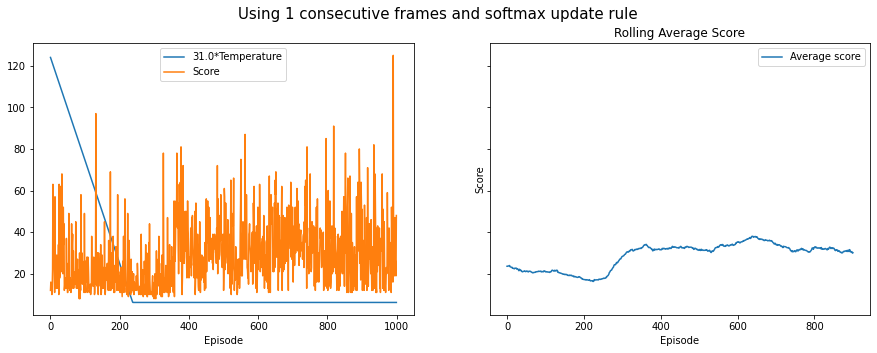

In [29]:
n_frames     = 0
update_type  = 'softmax'
scale        = 50
type_preproc = 2 

#initialize the exploration profile
my_profile_obj = exploration_profile(explor_type = 1, initial_temp = 4 , num_iterations = 1000)
my_profile     = my_profile_obj.get_profile()

start_time = time.time()
results1, net1 = training(my_profile,
                      n_frames = n_frames,
                      update_type = update_type,
                      preproc = (type_preproc, scale),
                      inter_channels  = 4)
end_time   = time.time()

# clear_output(wait = True)
print("Time taken for training was: ", end_time - start_time, "seconds")
plot_results(results1, my_profile, n_frames + 1, update_type)

EPISODE: 1 - FINAL SCORE: 26 - Temperature: 3.999999
EPISODE: 2 - FINAL SCORE: 18 - Temperature: 3.983999
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 3.967999
EPISODE: 4 - FINAL SCORE: 20 - Temperature: 3.951999
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 3.935999
EPISODE: 6 - FINAL SCORE: 20 - Temperature: 3.919999
EPISODE: 7 - FINAL SCORE: 15 - Temperature: 3.9039989999999998
EPISODE: 8 - FINAL SCORE: 41 - Temperature: 3.8879989999999998
EPISODE: 9 - FINAL SCORE: 11 - Temperature: 3.8719989999999997
EPISODE: 10 - FINAL SCORE: 14 - Temperature: 3.8559989999999997
EPISODE: 11 - FINAL SCORE: 20 - Temperature: 3.8399989999999997
EPISODE: 12 - FINAL SCORE: 29 - Temperature: 3.8239989999999997
EPISODE: 13 - FINAL SCORE: 16 - Temperature: 3.8079989999999997
EPISODE: 14 - FINAL SCORE: 22 - Temperature: 3.7919989999999997
EPISODE: 15 - FINAL SCORE: 10 - Temperature: 3.7759989999999997
EPISODE: 16 - FINAL SCORE: 21 - Temperature: 3.7599989999999996
EPISODE: 17 - FINAL SCORE: 12 - Temperature: 

EPISODE: 144 - FINAL SCORE: 10 - Temperature: 1.7119989999999998
EPISODE: 145 - FINAL SCORE: 17 - Temperature: 1.6959989999999998
EPISODE: 146 - FINAL SCORE: 14 - Temperature: 1.6799990000000002
EPISODE: 147 - FINAL SCORE: 14 - Temperature: 1.6639990000000002
EPISODE: 148 - FINAL SCORE: 31 - Temperature: 1.6479990000000002
EPISODE: 149 - FINAL SCORE: 17 - Temperature: 1.6319990000000002
EPISODE: 150 - FINAL SCORE: 10 - Temperature: 1.6159990000000002
EPISODE: 151 - FINAL SCORE: 41 - Temperature: 1.5999990000000002
EPISODE: 152 - FINAL SCORE: 13 - Temperature: 1.5839990000000002
EPISODE: 153 - FINAL SCORE: 13 - Temperature: 1.5679990000000001
EPISODE: 154 - FINAL SCORE: 31 - Temperature: 1.5519990000000001
EPISODE: 155 - FINAL SCORE: 14 - Temperature: 1.5359990000000001
EPISODE: 156 - FINAL SCORE: 18 - Temperature: 1.519999
EPISODE: 157 - FINAL SCORE: 24 - Temperature: 1.503999
EPISODE: 158 - FINAL SCORE: 36 - Temperature: 1.487999
EPISODE: 159 - FINAL SCORE: 15 - Temperature: 1.471999


EPISODE: 286 - FINAL SCORE: 14 - Temperature: 0.2
EPISODE: 287 - FINAL SCORE: 22 - Temperature: 0.2
EPISODE: 288 - FINAL SCORE: 28 - Temperature: 0.2
EPISODE: 289 - FINAL SCORE: 16 - Temperature: 0.2
EPISODE: 290 - FINAL SCORE: 13 - Temperature: 0.2
EPISODE: 291 - FINAL SCORE: 12 - Temperature: 0.2
EPISODE: 292 - FINAL SCORE: 18 - Temperature: 0.2
EPISODE: 293 - FINAL SCORE: 32 - Temperature: 0.2
EPISODE: 294 - FINAL SCORE: 31 - Temperature: 0.2
EPISODE: 295 - FINAL SCORE: 47 - Temperature: 0.2
EPISODE: 296 - FINAL SCORE: 40 - Temperature: 0.2
EPISODE: 297 - FINAL SCORE: 13 - Temperature: 0.2
EPISODE: 298 - FINAL SCORE: 18 - Temperature: 0.2
EPISODE: 299 - FINAL SCORE: 46 - Temperature: 0.2
EPISODE: 300 - FINAL SCORE: 20 - Temperature: 0.2
EPISODE: 301 - FINAL SCORE: 67 - Temperature: 0.2
EPISODE: 302 - FINAL SCORE: 67 - Temperature: 0.2
EPISODE: 303 - FINAL SCORE: 85 - Temperature: 0.2
EPISODE: 304 - FINAL SCORE: 16 - Temperature: 0.2
EPISODE: 305 - FINAL SCORE: 189 - Temperature: 0.2

EPISODE: 450 - FINAL SCORE: 30 - Temperature: 0.2
EPISODE: 451 - FINAL SCORE: 50 - Temperature: 0.2
EPISODE: 452 - FINAL SCORE: 13 - Temperature: 0.2
EPISODE: 453 - FINAL SCORE: 46 - Temperature: 0.2
EPISODE: 454 - FINAL SCORE: 39 - Temperature: 0.2
EPISODE: 455 - FINAL SCORE: 66 - Temperature: 0.2
EPISODE: 456 - FINAL SCORE: 21 - Temperature: 0.2
EPISODE: 457 - FINAL SCORE: 27 - Temperature: 0.2
EPISODE: 458 - FINAL SCORE: 24 - Temperature: 0.2
EPISODE: 459 - FINAL SCORE: 12 - Temperature: 0.2
EPISODE: 460 - FINAL SCORE: 54 - Temperature: 0.2
EPISODE: 461 - FINAL SCORE: 51 - Temperature: 0.2
EPISODE: 462 - FINAL SCORE: 109 - Temperature: 0.2
EPISODE: 463 - FINAL SCORE: 35 - Temperature: 0.2
EPISODE: 464 - FINAL SCORE: 41 - Temperature: 0.2
EPISODE: 465 - FINAL SCORE: 74 - Temperature: 0.2
EPISODE: 466 - FINAL SCORE: 20 - Temperature: 0.2
EPISODE: 467 - FINAL SCORE: 17 - Temperature: 0.2
EPISODE: 468 - FINAL SCORE: 10 - Temperature: 0.2
EPISODE: 469 - FINAL SCORE: 56 - Temperature: 0.2

EPISODE: 614 - FINAL SCORE: 17 - Temperature: 0.2
EPISODE: 615 - FINAL SCORE: 34 - Temperature: 0.2
EPISODE: 616 - FINAL SCORE: 37 - Temperature: 0.2
EPISODE: 617 - FINAL SCORE: 84 - Temperature: 0.2
EPISODE: 618 - FINAL SCORE: 110 - Temperature: 0.2
EPISODE: 619 - FINAL SCORE: 136 - Temperature: 0.2
EPISODE: 620 - FINAL SCORE: 140 - Temperature: 0.2
EPISODE: 621 - FINAL SCORE: 22 - Temperature: 0.2
EPISODE: 622 - FINAL SCORE: 60 - Temperature: 0.2
EPISODE: 623 - FINAL SCORE: 11 - Temperature: 0.2
EPISODE: 624 - FINAL SCORE: 68 - Temperature: 0.2
EPISODE: 625 - FINAL SCORE: 12 - Temperature: 0.2
EPISODE: 626 - FINAL SCORE: 151 - Temperature: 0.2
EPISODE: 627 - FINAL SCORE: 29 - Temperature: 0.2
EPISODE: 628 - FINAL SCORE: 89 - Temperature: 0.2
EPISODE: 629 - FINAL SCORE: 23 - Temperature: 0.2
EPISODE: 630 - FINAL SCORE: 54 - Temperature: 0.2
EPISODE: 631 - FINAL SCORE: 78 - Temperature: 0.2
EPISODE: 632 - FINAL SCORE: 246 - Temperature: 0.2
EPISODE: 633 - FINAL SCORE: 81 - Temperature:

EPISODE: 777 - FINAL SCORE: 78 - Temperature: 0.2
EPISODE: 778 - FINAL SCORE: 31 - Temperature: 0.2
EPISODE: 779 - FINAL SCORE: 43 - Temperature: 0.2
EPISODE: 780 - FINAL SCORE: 20 - Temperature: 0.2
EPISODE: 781 - FINAL SCORE: 153 - Temperature: 0.2
EPISODE: 782 - FINAL SCORE: 26 - Temperature: 0.2
EPISODE: 783 - FINAL SCORE: 17 - Temperature: 0.2
EPISODE: 784 - FINAL SCORE: 37 - Temperature: 0.2
EPISODE: 785 - FINAL SCORE: 121 - Temperature: 0.2
EPISODE: 786 - FINAL SCORE: 98 - Temperature: 0.2
EPISODE: 787 - FINAL SCORE: 23 - Temperature: 0.2
EPISODE: 788 - FINAL SCORE: 12 - Temperature: 0.2
EPISODE: 789 - FINAL SCORE: 90 - Temperature: 0.2
EPISODE: 790 - FINAL SCORE: 11 - Temperature: 0.2
EPISODE: 791 - FINAL SCORE: 15 - Temperature: 0.2
EPISODE: 792 - FINAL SCORE: 9 - Temperature: 0.2
EPISODE: 793 - FINAL SCORE: 28 - Temperature: 0.2
EPISODE: 794 - FINAL SCORE: 81 - Temperature: 0.2
EPISODE: 795 - FINAL SCORE: 51 - Temperature: 0.2
EPISODE: 796 - FINAL SCORE: 27 - Temperature: 0.2

EPISODE: 941 - FINAL SCORE: 40 - Temperature: 0.2
EPISODE: 942 - FINAL SCORE: 21 - Temperature: 0.2
EPISODE: 943 - FINAL SCORE: 83 - Temperature: 0.2
EPISODE: 944 - FINAL SCORE: 119 - Temperature: 0.2
EPISODE: 945 - FINAL SCORE: 89 - Temperature: 0.2
EPISODE: 946 - FINAL SCORE: 110 - Temperature: 0.2
EPISODE: 947 - FINAL SCORE: 41 - Temperature: 0.2
EPISODE: 948 - FINAL SCORE: 81 - Temperature: 0.2
EPISODE: 949 - FINAL SCORE: 16 - Temperature: 0.2
EPISODE: 950 - FINAL SCORE: 63 - Temperature: 0.2
EPISODE: 951 - FINAL SCORE: 119 - Temperature: 0.2
EPISODE: 952 - FINAL SCORE: 34 - Temperature: 0.2
EPISODE: 953 - FINAL SCORE: 15 - Temperature: 0.2
EPISODE: 954 - FINAL SCORE: 30 - Temperature: 0.2
EPISODE: 955 - FINAL SCORE: 85 - Temperature: 0.2
EPISODE: 956 - FINAL SCORE: 47 - Temperature: 0.2
EPISODE: 957 - FINAL SCORE: 52 - Temperature: 0.2
EPISODE: 958 - FINAL SCORE: 42 - Temperature: 0.2
EPISODE: 959 - FINAL SCORE: 26 - Temperature: 0.2
EPISODE: 960 - FINAL SCORE: 23 - Temperature: 0

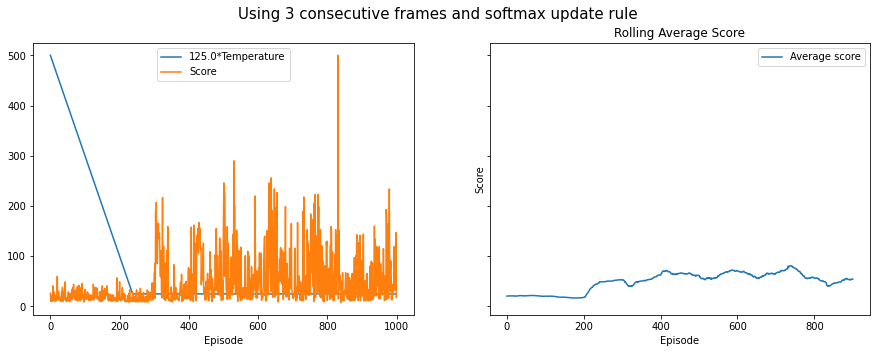

In [30]:
n_frames     = 2
update_type  = 'softmax'
scale        = 50
type_preproc = 2 

#initialize the exploration profile
my_profile_obj = exploration_profile(explor_type = 1, initial_temp = 4 , num_iterations = 1000)
my_profile     = my_profile_obj.get_profile()

start_time = time.time()
results2, net2 = training(my_profile,
                      n_frames = n_frames,
                      update_type = update_type,
                      preproc = (type_preproc, scale),
                      inter_channels  = 4)
end_time   = time.time()

# clear_output(wait = True)
print("Time taken for training was: ", end_time - start_time, "seconds")
plot_results(results2, my_profile, n_frames + 1, update_type)

EPISODE: 1 - FINAL SCORE: 18 - Temperature: 3.999999
EPISODE: 2 - FINAL SCORE: 18 - Temperature: 3.983999
EPISODE: 3 - FINAL SCORE: 12 - Temperature: 3.967999
EPISODE: 4 - FINAL SCORE: 11 - Temperature: 3.951999
EPISODE: 5 - FINAL SCORE: 9 - Temperature: 3.935999
EPISODE: 6 - FINAL SCORE: 14 - Temperature: 3.919999
EPISODE: 7 - FINAL SCORE: 32 - Temperature: 3.9039989999999998
EPISODE: 8 - FINAL SCORE: 55 - Temperature: 3.8879989999999998
EPISODE: 9 - FINAL SCORE: 13 - Temperature: 3.8719989999999997
EPISODE: 10 - FINAL SCORE: 15 - Temperature: 3.8559989999999997
EPISODE: 11 - FINAL SCORE: 29 - Temperature: 3.8399989999999997
EPISODE: 12 - FINAL SCORE: 36 - Temperature: 3.8239989999999997
EPISODE: 13 - FINAL SCORE: 17 - Temperature: 3.8079989999999997
EPISODE: 14 - FINAL SCORE: 15 - Temperature: 3.7919989999999997
EPISODE: 15 - FINAL SCORE: 13 - Temperature: 3.7759989999999997
EPISODE: 16 - FINAL SCORE: 19 - Temperature: 3.7599989999999996
EPISODE: 17 - FINAL SCORE: 13 - Temperature: 3

EPISODE: 144 - FINAL SCORE: 14 - Temperature: 1.7119989999999998
EPISODE: 145 - FINAL SCORE: 16 - Temperature: 1.6959989999999998
EPISODE: 146 - FINAL SCORE: 9 - Temperature: 1.6799990000000002
EPISODE: 147 - FINAL SCORE: 15 - Temperature: 1.6639990000000002
EPISODE: 148 - FINAL SCORE: 23 - Temperature: 1.6479990000000002
EPISODE: 149 - FINAL SCORE: 21 - Temperature: 1.6319990000000002
EPISODE: 150 - FINAL SCORE: 31 - Temperature: 1.6159990000000002
EPISODE: 151 - FINAL SCORE: 17 - Temperature: 1.5999990000000002
EPISODE: 152 - FINAL SCORE: 28 - Temperature: 1.5839990000000002
EPISODE: 153 - FINAL SCORE: 45 - Temperature: 1.5679990000000001
EPISODE: 154 - FINAL SCORE: 18 - Temperature: 1.5519990000000001
EPISODE: 155 - FINAL SCORE: 22 - Temperature: 1.5359990000000001
EPISODE: 156 - FINAL SCORE: 22 - Temperature: 1.519999
EPISODE: 157 - FINAL SCORE: 13 - Temperature: 1.503999
EPISODE: 158 - FINAL SCORE: 20 - Temperature: 1.487999
EPISODE: 159 - FINAL SCORE: 19 - Temperature: 1.471999
E

EPISODE: 286 - FINAL SCORE: 50 - Temperature: 0.2
EPISODE: 287 - FINAL SCORE: 35 - Temperature: 0.2
EPISODE: 288 - FINAL SCORE: 50 - Temperature: 0.2
EPISODE: 289 - FINAL SCORE: 64 - Temperature: 0.2
EPISODE: 290 - FINAL SCORE: 40 - Temperature: 0.2
EPISODE: 291 - FINAL SCORE: 22 - Temperature: 0.2
EPISODE: 292 - FINAL SCORE: 27 - Temperature: 0.2
EPISODE: 293 - FINAL SCORE: 20 - Temperature: 0.2
EPISODE: 294 - FINAL SCORE: 25 - Temperature: 0.2
EPISODE: 295 - FINAL SCORE: 33 - Temperature: 0.2
EPISODE: 296 - FINAL SCORE: 19 - Temperature: 0.2
EPISODE: 297 - FINAL SCORE: 109 - Temperature: 0.2
EPISODE: 298 - FINAL SCORE: 41 - Temperature: 0.2
EPISODE: 299 - FINAL SCORE: 56 - Temperature: 0.2
EPISODE: 300 - FINAL SCORE: 306 - Temperature: 0.2
EPISODE: 301 - FINAL SCORE: 125 - Temperature: 0.2
EPISODE: 302 - FINAL SCORE: 128 - Temperature: 0.2
EPISODE: 303 - FINAL SCORE: 181 - Temperature: 0.2
EPISODE: 304 - FINAL SCORE: 212 - Temperature: 0.2
EPISODE: 305 - FINAL SCORE: 198 - Temperatur

EPISODE: 450 - FINAL SCORE: 10 - Temperature: 0.2
EPISODE: 451 - FINAL SCORE: 109 - Temperature: 0.2
EPISODE: 452 - FINAL SCORE: 24 - Temperature: 0.2
EPISODE: 453 - FINAL SCORE: 25 - Temperature: 0.2
EPISODE: 454 - FINAL SCORE: 15 - Temperature: 0.2
EPISODE: 455 - FINAL SCORE: 41 - Temperature: 0.2
EPISODE: 456 - FINAL SCORE: 90 - Temperature: 0.2
EPISODE: 457 - FINAL SCORE: 30 - Temperature: 0.2
EPISODE: 458 - FINAL SCORE: 17 - Temperature: 0.2
EPISODE: 459 - FINAL SCORE: 67 - Temperature: 0.2
EPISODE: 460 - FINAL SCORE: 18 - Temperature: 0.2
EPISODE: 461 - FINAL SCORE: 21 - Temperature: 0.2
EPISODE: 462 - FINAL SCORE: 17 - Temperature: 0.2
EPISODE: 463 - FINAL SCORE: 21 - Temperature: 0.2
EPISODE: 464 - FINAL SCORE: 29 - Temperature: 0.2
EPISODE: 465 - FINAL SCORE: 29 - Temperature: 0.2
EPISODE: 466 - FINAL SCORE: 15 - Temperature: 0.2
EPISODE: 467 - FINAL SCORE: 18 - Temperature: 0.2
EPISODE: 468 - FINAL SCORE: 31 - Temperature: 0.2
EPISODE: 469 - FINAL SCORE: 14 - Temperature: 0.2

EPISODE: 614 - FINAL SCORE: 56 - Temperature: 0.2
EPISODE: 615 - FINAL SCORE: 38 - Temperature: 0.2
EPISODE: 616 - FINAL SCORE: 73 - Temperature: 0.2
EPISODE: 617 - FINAL SCORE: 22 - Temperature: 0.2
EPISODE: 618 - FINAL SCORE: 34 - Temperature: 0.2
EPISODE: 619 - FINAL SCORE: 93 - Temperature: 0.2
EPISODE: 620 - FINAL SCORE: 57 - Temperature: 0.2
EPISODE: 621 - FINAL SCORE: 23 - Temperature: 0.2
EPISODE: 622 - FINAL SCORE: 63 - Temperature: 0.2
EPISODE: 623 - FINAL SCORE: 24 - Temperature: 0.2
EPISODE: 624 - FINAL SCORE: 18 - Temperature: 0.2
EPISODE: 625 - FINAL SCORE: 17 - Temperature: 0.2
EPISODE: 626 - FINAL SCORE: 17 - Temperature: 0.2
EPISODE: 627 - FINAL SCORE: 56 - Temperature: 0.2
EPISODE: 628 - FINAL SCORE: 66 - Temperature: 0.2
EPISODE: 629 - FINAL SCORE: 36 - Temperature: 0.2
EPISODE: 630 - FINAL SCORE: 38 - Temperature: 0.2
EPISODE: 631 - FINAL SCORE: 73 - Temperature: 0.2
EPISODE: 632 - FINAL SCORE: 37 - Temperature: 0.2
EPISODE: 633 - FINAL SCORE: 71 - Temperature: 0.2


EPISODE: 778 - FINAL SCORE: 14 - Temperature: 0.2
EPISODE: 779 - FINAL SCORE: 58 - Temperature: 0.2
EPISODE: 780 - FINAL SCORE: 15 - Temperature: 0.2
EPISODE: 781 - FINAL SCORE: 40 - Temperature: 0.2
EPISODE: 782 - FINAL SCORE: 15 - Temperature: 0.2
EPISODE: 783 - FINAL SCORE: 14 - Temperature: 0.2
EPISODE: 784 - FINAL SCORE: 18 - Temperature: 0.2
EPISODE: 785 - FINAL SCORE: 36 - Temperature: 0.2
EPISODE: 786 - FINAL SCORE: 13 - Temperature: 0.2
EPISODE: 787 - FINAL SCORE: 13 - Temperature: 0.2
EPISODE: 788 - FINAL SCORE: 16 - Temperature: 0.2
EPISODE: 789 - FINAL SCORE: 33 - Temperature: 0.2
EPISODE: 790 - FINAL SCORE: 13 - Temperature: 0.2
EPISODE: 791 - FINAL SCORE: 19 - Temperature: 0.2
EPISODE: 792 - FINAL SCORE: 24 - Temperature: 0.2
EPISODE: 793 - FINAL SCORE: 27 - Temperature: 0.2
EPISODE: 794 - FINAL SCORE: 18 - Temperature: 0.2
EPISODE: 795 - FINAL SCORE: 20 - Temperature: 0.2
EPISODE: 796 - FINAL SCORE: 13 - Temperature: 0.2
EPISODE: 797 - FINAL SCORE: 73 - Temperature: 0.2


EPISODE: 942 - FINAL SCORE: 66 - Temperature: 0.2
EPISODE: 943 - FINAL SCORE: 53 - Temperature: 0.2
EPISODE: 944 - FINAL SCORE: 41 - Temperature: 0.2
EPISODE: 945 - FINAL SCORE: 132 - Temperature: 0.2
EPISODE: 946 - FINAL SCORE: 24 - Temperature: 0.2
EPISODE: 947 - FINAL SCORE: 136 - Temperature: 0.2
EPISODE: 948 - FINAL SCORE: 29 - Temperature: 0.2
EPISODE: 949 - FINAL SCORE: 24 - Temperature: 0.2
EPISODE: 950 - FINAL SCORE: 71 - Temperature: 0.2
EPISODE: 951 - FINAL SCORE: 20 - Temperature: 0.2
EPISODE: 952 - FINAL SCORE: 24 - Temperature: 0.2
EPISODE: 953 - FINAL SCORE: 15 - Temperature: 0.2
EPISODE: 954 - FINAL SCORE: 219 - Temperature: 0.2
EPISODE: 955 - FINAL SCORE: 52 - Temperature: 0.2
EPISODE: 956 - FINAL SCORE: 146 - Temperature: 0.2
EPISODE: 957 - FINAL SCORE: 38 - Temperature: 0.2
EPISODE: 958 - FINAL SCORE: 214 - Temperature: 0.2
EPISODE: 959 - FINAL SCORE: 128 - Temperature: 0.2
EPISODE: 960 - FINAL SCORE: 43 - Temperature: 0.2
EPISODE: 961 - FINAL SCORE: 98 - Temperature

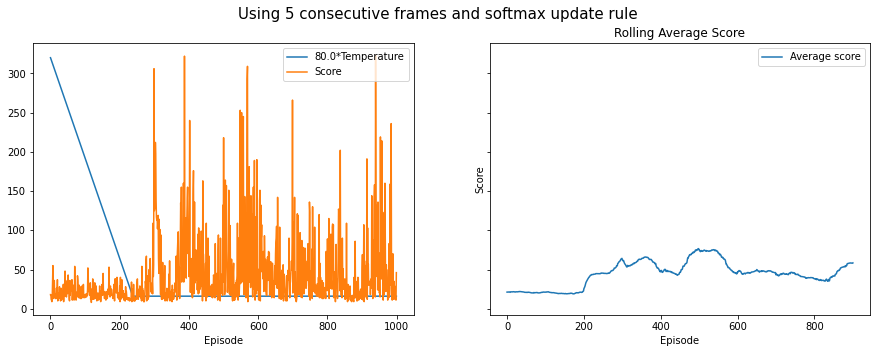

In [31]:
n_frames     = 4
update_type  = 'softmax'
scale        = 50
type_preproc = 2 

#initialize the exploration profile
my_profile_obj = exploration_profile(explor_type = 1, initial_temp = 4, num_iterations = 1000)
my_profile     = my_profile_obj.get_profile()

start_time = time.time()
results3, net3 = training(my_profile,
                      n_frames = n_frames,
                      update_type = update_type,
                      preproc = (type_preproc, scale),
                      inter_channels  = 4)
end_time   = time.time()

# clear_output(wait = True)
print("Time taken for training was: ", end_time - start_time, "seconds")
plot_results(results3, my_profile, n_frames + 1, update_type)

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 29 - Temperature: 3.966866922953173
EPISODE: 3 - FINAL SCORE: 35 - Temperature: 3.934008296104994
EPISODE: 4 - FINAL SCORE: 49 - Temperature: 3.901421846110568
EPISODE: 5 - FINAL SCORE: 12 - Temperature: 3.869105318455729
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 3.8370564773010587
EPISODE: 7 - FINAL SCORE: 13 - Temperature: 3.8052731053271978
EPISODE: 8 - FINAL SCORE: 19 - Temperature: 3.773753003581442
EPISODE: 9 - FINAL SCORE: 63 - Temperature: 3.742493991325602
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 3.7114939058851326
EPISODE: 11 - FINAL SCORE: 22 - Temperature: 3.6807506024995025
EPISODE: 12 - FINAL SCORE: 19 - Temperature: 3.6502619541738097
EPISODE: 13 - FINAL SCORE: 14 - Temperature: 3.620025851531624
EPISODE: 14 - FINAL SCORE: 10 - Temperature: 3.5900402026690483
EPISODE: 15 - FINAL SCORE: 14 - Temperature: 3.5603029330099885
EPISODE: 16 - FINAL SCORE: 25 - Temperature: 3.5308119851626225
EPISODE

EPISODE: 130 - FINAL SCORE: 22 - Temperature: 1.3679353039025004
EPISODE: 131 - FINAL SCORE: 26 - Temperature: 1.3566043274476813
EPISODE: 132 - FINAL SCORE: 54 - Temperature: 1.3453672085218358
EPISODE: 133 - FINAL SCORE: 28 - Temperature: 1.3342231696777787
EPISODE: 134 - FINAL SCORE: 13 - Temperature: 1.3231714399081296
EPISODE: 135 - FINAL SCORE: 15 - Temperature: 1.3122112545919704
EPISODE: 136 - FINAL SCORE: 12 - Temperature: 1.3013418554419431
EPISODE: 137 - FINAL SCORE: 21 - Temperature: 1.2905624904517885
EPISODE: 138 - FINAL SCORE: 21 - Temperature: 1.2798724138443174
EPISODE: 139 - FINAL SCORE: 14 - Temperature: 1.2692708860198143
EPISODE: 140 - FINAL SCORE: 16 - Temperature: 1.258757173504867
EPISODE: 141 - FINAL SCORE: 19 - Temperature: 1.2483305489016214
EPISODE: 142 - FINAL SCORE: 12 - Temperature: 1.2379902908374552
EPISODE: 143 - FINAL SCORE: 14 - Temperature: 1.2277356839150697
EPISODE: 144 - FINAL SCORE: 12 - Temperature: 1.2175660186629955
EPISODE: 145 - FINAL SCORE

EPISODE: 257 - FINAL SCORE: 11 - Temperature: 0.47565913816590616
EPISODE: 258 - FINAL SCORE: 12 - Temperature: 0.4717191254476866
EPISODE: 259 - FINAL SCORE: 13 - Temperature: 0.4678117489157066
EPISODE: 260 - FINAL SCORE: 16 - Temperature: 0.46393673823564785
EPISODE: 261 - FINAL SCORE: 11 - Temperature: 0.460093825312444
EPISODE: 262 - FINAL SCORE: 10 - Temperature: 0.4562827442717324
EPISODE: 263 - FINAL SCORE: 10 - Temperature: 0.45250323144145915
EPISODE: 264 - FINAL SCORE: 9 - Temperature: 0.4487550253336371
EPISODE: 265 - FINAL SCORE: 28 - Temperature: 0.44503786662625455
EPISODE: 266 - FINAL SCORE: 12 - Temperature: 0.44135149814533375
EPISODE: 267 - FINAL SCORE: 11 - Temperature: 0.4376956648471383
EPISODE: 268 - FINAL SCORE: 18 - Temperature: 0.4340701138005277
EPISODE: 269 - FINAL SCORE: 19 - Temperature: 0.4304745941694582
EPISODE: 270 - FINAL SCORE: 20 - Temperature: 0.42690885719562865
EPISODE: 271 - FINAL SCORE: 27 - Temperature: 0.4233726561812698
EPISODE: 272 - FINAL 

EPISODE: 383 - FINAL SCORE: 23 - Temperature: 0.16677789620972458
EPISODE: 384 - FINAL SCORE: 23 - Temperature: 0.16539642998851845
EPISODE: 385 - FINAL SCORE: 14 - Temperature: 0.16402640682399852
EPISODE: 386 - FINAL SCORE: 14 - Temperature: 0.16266773193024509
EPISODE: 387 - FINAL SCORE: 35 - Temperature: 0.16132031130647573
EPISODE: 388 - FINAL SCORE: 38 - Temperature: 0.15998405173054184
EPISODE: 389 - FINAL SCORE: 35 - Temperature: 0.15865886075247893
EPISODE: 390 - FINAL SCORE: 13 - Temperature: 0.15734464668811052
EPISODE: 391 - FINAL SCORE: 30 - Temperature: 0.1560413186127048
EPISODE: 392 - FINAL SCORE: 26 - Temperature: 0.15474878635468398
EPISODE: 393 - FINAL SCORE: 12 - Temperature: 0.1534669604893858
EPISODE: 394 - FINAL SCORE: 29 - Temperature: 0.1521957523328765
EPISODE: 395 - FINAL SCORE: 32 - Temperature: 0.15093507393581526
EPISODE: 396 - FINAL SCORE: 46 - Temperature: 0.1496848380773693
EPISODE: 397 - FINAL SCORE: 54 - Temperature: 0.14844495825917944
EPISODE: 398 -

EPISODE: 508 - FINAL SCORE: 57 - Temperature: 0.058964890680961626
EPISODE: 509 - FINAL SCORE: 102 - Temperature: 0.058476468614464115
EPISODE: 510 - FINAL SCORE: 39 - Temperature: 0.057992092279456765
EPISODE: 511 - FINAL SCORE: 52 - Temperature: 0.05751172816405628
EPISODE: 512 - FINAL SCORE: 48 - Temperature: 0.05703534303396732
EPISODE: 513 - FINAL SCORE: 22 - Temperature: 0.05656290393018316
EPISODE: 514 - FINAL SCORE: 57 - Temperature: 0.0560943781667054
EPISODE: 515 - FINAL SCORE: 29 - Temperature: 0.055629733328282575
EPISODE: 516 - FINAL SCORE: 26 - Temperature: 0.05516893726816747
EPISODE: 517 - FINAL SCORE: 32 - Temperature: 0.05471195810589303
EPISODE: 518 - FINAL SCORE: 32 - Temperature: 0.054258764225066695
EPISODE: 519 - FINAL SCORE: 53 - Temperature: 0.053809324271183005
EPISODE: 520 - FINAL SCORE: 43 - Temperature: 0.053363607149454304
EPISODE: 521 - FINAL SCORE: 45 - Temperature: 0.05292158202265944
EPISODE: 522 - FINAL SCORE: 42 - Temperature: 0.052483218309010246
EP

EPISODE: 632 - FINAL SCORE: 41 - Temperature: 0.021021362633154253
EPISODE: 633 - FINAL SCORE: 26 - Temperature: 0.020847237026215854
EPISODE: 634 - FINAL SCORE: 57 - Temperature: 0.020674553748565087
EPISODE: 635 - FINAL SCORE: 28 - Temperature: 0.020503300853000093
EPISODE: 636 - FINAL SCORE: 39 - Temperature: 0.02033346649128091
EPISODE: 637 - FINAL SCORE: 50 - Temperature: 0.02016503891330974
EPISODE: 638 - FINAL SCORE: 46 - Temperature: 0.019998006466318
EPISODE: 639 - FINAL SCORE: 68 - Temperature: 0.019832357594060136
EPISODE: 640 - FINAL SCORE: 22 - Temperature: 0.019668080836014082
EPISODE: 641 - FINAL SCORE: 39 - Temperature: 0.019505164826588362
EPISODE: 642 - FINAL SCORE: 25 - Temperature: 0.019343598294335757
EPISODE: 643 - FINAL SCORE: 30 - Temperature: 0.019183370061173485
EPISODE: 644 - FINAL SCORE: 25 - Temperature: 0.019024469041609822
EPISODE: 645 - FINAL SCORE: 65 - Temperature: 0.01886688424197716
EPISODE: 646 - FINAL SCORE: 33 - Temperature: 0.018710604759671415
E

EPISODE: 755 - FINAL SCORE: 44 - Temperature: 0.007556846325109152
EPISODE: 756 - FINAL SCORE: 40 - Temperature: 0.007494250932228934
EPISODE: 757 - FINAL SCORE: 78 - Temperature: 0.007432174033842485
EPISODE: 758 - FINAL SCORE: 38 - Temperature: 0.007370611335120303
EPISODE: 759 - FINAL SCORE: 66 - Temperature: 0.007309558576808113
EPISODE: 760 - FINAL SCORE: 23 - Temperature: 0.007249011534932194
EPISODE: 761 - FINAL SCORE: 24 - Temperature: 0.007188966020507132
EPISODE: 762 - FINAL SCORE: 19 - Temperature: 0.007129417879246011
EPISODE: 763 - FINAL SCORE: 71 - Temperature: 0.00707036299127299
EPISODE: 764 - FINAL SCORE: 60 - Temperature: 0.0070117972708382695
EPISODE: 765 - FINAL SCORE: 25 - Temperature: 0.006953716666035416
EPISODE: 766 - FINAL SCORE: 33 - Temperature: 0.006896117158521026
EPISODE: 767 - FINAL SCORE: 39 - Temperature: 0.0068389947632367205
EPISODE: 768 - FINAL SCORE: 45 - Temperature: 0.006782345528133429
EPISODE: 769 - FINAL SCORE: 23 - Temperature: 0.0067261655338

EPISODE: 877 - FINAL SCORE: 50 - Temperature: 0.0027392563489110696
EPISODE: 878 - FINAL SCORE: 21 - Temperature: 0.0027165663509961992
EPISODE: 879 - FINAL SCORE: 47 - Temperature: 0.0026940643004436057
EPISODE: 880 - FINAL SCORE: 48 - Temperature: 0.0026717486404346795
EPISODE: 881 - FINAL SCORE: 36 - Temperature: 0.00264961782704636
EPISODE: 882 - FINAL SCORE: 27 - Temperature: 0.0026276703291443168
EPISODE: 883 - FINAL SCORE: 42 - Temperature: 0.002605904628277017
EPISODE: 884 - FINAL SCORE: 43 - Temperature: 0.0025843192185706705
EPISODE: 885 - FINAL SCORE: 87 - Temperature: 0.0025629126066250463
EPISODE: 886 - FINAL SCORE: 43 - Temperature: 0.0025416833114101484
EPISODE: 887 - FINAL SCORE: 34 - Temperature: 0.0025206298641637513
EPISODE: 888 - FINAL SCORE: 33 - Temperature: 0.002499750808289784
EPISODE: 889 - FINAL SCORE: 43 - Temperature: 0.0024790446992575504
EPISODE: 890 - FINAL SCORE: 32 - Temperature: 0.002458510104501793
EPISODE: 891 - FINAL SCORE: 35 - Temperature: 0.00243

EPISODE: 998 - FINAL SCORE: 30 - Temperature: 0.001001237537000634
EPISODE: 999 - FINAL SCORE: 13 - Temperature: 0.0009929440168867296
EPISODE: 1000 - FINAL SCORE: 37 - Temperature: 0.000984719194233056

Time taken for training was:  2432.770488023758 seconds


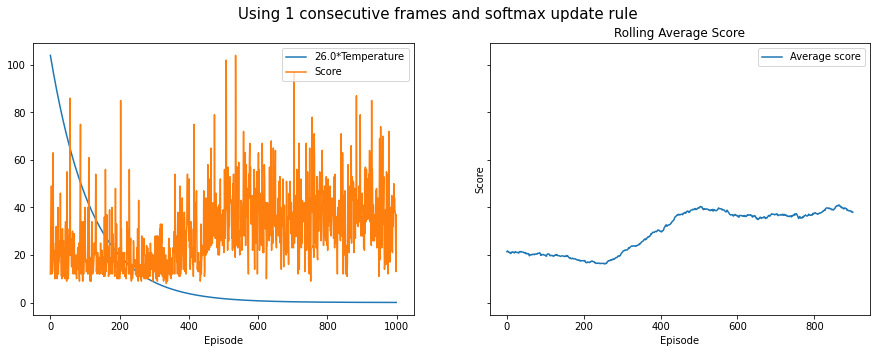

In [32]:
n_frames     = 0
update_type  = 'softmax'
scale        = 50
type_preproc = 2 

#initialize the exploration profile
my_profile_obj = exploration_profile(explor_type = 2, initial_temp = 4 , num_iterations = 1000)
my_profile     = my_profile_obj.get_profile()

start_time = time.time()
results4, net4 = training(my_profile,
                      n_frames = n_frames,
                      update_type = update_type,
                      preproc = (type_preproc, scale),
                      inter_channels  = 4)
end_time   = time.time()

# clear_output(wait = True)
print("Time taken for training was: ", end_time - start_time, "seconds")
plot_results(results4, my_profile, n_frames + 1, update_type)

EPISODE: 1 - FINAL SCORE: 34 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 14 - Temperature: 3.966866922953173
EPISODE: 3 - FINAL SCORE: 8 - Temperature: 3.934008296104994
EPISODE: 4 - FINAL SCORE: 42 - Temperature: 3.901421846110568
EPISODE: 5 - FINAL SCORE: 9 - Temperature: 3.869105318455729
EPISODE: 6 - FINAL SCORE: 12 - Temperature: 3.8370564773010587
EPISODE: 7 - FINAL SCORE: 14 - Temperature: 3.8052731053271978
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 3.773753003581442
EPISODE: 9 - FINAL SCORE: 28 - Temperature: 3.742493991325602
EPISODE: 10 - FINAL SCORE: 13 - Temperature: 3.7114939058851326
EPISODE: 11 - FINAL SCORE: 28 - Temperature: 3.6807506024995025
EPISODE: 12 - FINAL SCORE: 35 - Temperature: 3.6502619541738097
EPISODE: 13 - FINAL SCORE: 22 - Temperature: 3.620025851531624
EPISODE: 14 - FINAL SCORE: 30 - Temperature: 3.5900402026690483
EPISODE: 15 - FINAL SCORE: 20 - Temperature: 3.5603029330099885
EPISODE: 16 - FINAL SCORE: 25 - Temperature: 3.5308119851626225
EPISODE: 

EPISODE: 130 - FINAL SCORE: 40 - Temperature: 1.3679353039025004
EPISODE: 131 - FINAL SCORE: 19 - Temperature: 1.3566043274476813
EPISODE: 132 - FINAL SCORE: 18 - Temperature: 1.3453672085218358
EPISODE: 133 - FINAL SCORE: 26 - Temperature: 1.3342231696777787
EPISODE: 134 - FINAL SCORE: 25 - Temperature: 1.3231714399081296
EPISODE: 135 - FINAL SCORE: 18 - Temperature: 1.3122112545919704
EPISODE: 136 - FINAL SCORE: 11 - Temperature: 1.3013418554419431
EPISODE: 137 - FINAL SCORE: 91 - Temperature: 1.2905624904517885
EPISODE: 138 - FINAL SCORE: 16 - Temperature: 1.2798724138443174
EPISODE: 139 - FINAL SCORE: 18 - Temperature: 1.2692708860198143
EPISODE: 140 - FINAL SCORE: 28 - Temperature: 1.258757173504867
EPISODE: 141 - FINAL SCORE: 12 - Temperature: 1.2483305489016214
EPISODE: 142 - FINAL SCORE: 14 - Temperature: 1.2379902908374552
EPISODE: 143 - FINAL SCORE: 16 - Temperature: 1.2277356839150697
EPISODE: 144 - FINAL SCORE: 13 - Temperature: 1.2175660186629955
EPISODE: 145 - FINAL SCORE

EPISODE: 257 - FINAL SCORE: 19 - Temperature: 0.47565913816590616
EPISODE: 258 - FINAL SCORE: 36 - Temperature: 0.4717191254476866
EPISODE: 259 - FINAL SCORE: 21 - Temperature: 0.4678117489157066
EPISODE: 260 - FINAL SCORE: 10 - Temperature: 0.46393673823564785
EPISODE: 261 - FINAL SCORE: 44 - Temperature: 0.460093825312444
EPISODE: 262 - FINAL SCORE: 29 - Temperature: 0.4562827442717324
EPISODE: 263 - FINAL SCORE: 38 - Temperature: 0.45250323144145915
EPISODE: 264 - FINAL SCORE: 10 - Temperature: 0.4487550253336371
EPISODE: 265 - FINAL SCORE: 13 - Temperature: 0.44503786662625455
EPISODE: 266 - FINAL SCORE: 21 - Temperature: 0.44135149814533375
EPISODE: 267 - FINAL SCORE: 38 - Temperature: 0.4376956648471383
EPISODE: 268 - FINAL SCORE: 11 - Temperature: 0.4340701138005277
EPISODE: 269 - FINAL SCORE: 13 - Temperature: 0.4304745941694582
EPISODE: 270 - FINAL SCORE: 14 - Temperature: 0.42690885719562865
EPISODE: 271 - FINAL SCORE: 41 - Temperature: 0.4233726561812698
EPISODE: 272 - FINAL

EPISODE: 382 - FINAL SCORE: 18 - Temperature: 0.16817090106523175
EPISODE: 383 - FINAL SCORE: 83 - Temperature: 0.16677789620972458
EPISODE: 384 - FINAL SCORE: 60 - Temperature: 0.16539642998851845
EPISODE: 385 - FINAL SCORE: 38 - Temperature: 0.16402640682399852
EPISODE: 386 - FINAL SCORE: 31 - Temperature: 0.16266773193024509
EPISODE: 387 - FINAL SCORE: 18 - Temperature: 0.16132031130647573
EPISODE: 388 - FINAL SCORE: 43 - Temperature: 0.15998405173054184
EPISODE: 389 - FINAL SCORE: 47 - Temperature: 0.15865886075247893
EPISODE: 390 - FINAL SCORE: 16 - Temperature: 0.15734464668811052
EPISODE: 391 - FINAL SCORE: 36 - Temperature: 0.1560413186127048
EPISODE: 392 - FINAL SCORE: 18 - Temperature: 0.15474878635468398
EPISODE: 393 - FINAL SCORE: 84 - Temperature: 0.1534669604893858
EPISODE: 394 - FINAL SCORE: 103 - Temperature: 0.1521957523328765
EPISODE: 395 - FINAL SCORE: 33 - Temperature: 0.15093507393581526
EPISODE: 396 - FINAL SCORE: 63 - Temperature: 0.1496848380773693
EPISODE: 397 

EPISODE: 506 - FINAL SCORE: 37 - Temperature: 0.059954007457830666
EPISODE: 507 - FINAL SCORE: 54 - Temperature: 0.059457392270739075
EPISODE: 508 - FINAL SCORE: 42 - Temperature: 0.058964890680961626
EPISODE: 509 - FINAL SCORE: 14 - Temperature: 0.058476468614464115
EPISODE: 510 - FINAL SCORE: 17 - Temperature: 0.057992092279456765
EPISODE: 511 - FINAL SCORE: 44 - Temperature: 0.05751172816405628
EPISODE: 512 - FINAL SCORE: 15 - Temperature: 0.05703534303396732
EPISODE: 513 - FINAL SCORE: 18 - Temperature: 0.05656290393018316
EPISODE: 514 - FINAL SCORE: 52 - Temperature: 0.0560943781667054
EPISODE: 515 - FINAL SCORE: 85 - Temperature: 0.055629733328282575
EPISODE: 516 - FINAL SCORE: 49 - Temperature: 0.05516893726816747
EPISODE: 517 - FINAL SCORE: 18 - Temperature: 0.05471195810589303
EPISODE: 518 - FINAL SCORE: 19 - Temperature: 0.054258764225066695
EPISODE: 519 - FINAL SCORE: 33 - Temperature: 0.053809324271183005
EPISODE: 520 - FINAL SCORE: 24 - Temperature: 0.053363607149454304
EP

EPISODE: 629 - FINAL SCORE: 99 - Temperature: 0.021552514403548554
EPISODE: 630 - FINAL SCORE: 37 - Temperature: 0.021373989123477148
EPISODE: 631 - FINAL SCORE: 14 - Temperature: 0.021196942616370597
EPISODE: 632 - FINAL SCORE: 127 - Temperature: 0.021021362633154253
EPISODE: 633 - FINAL SCORE: 37 - Temperature: 0.020847237026215854
EPISODE: 634 - FINAL SCORE: 180 - Temperature: 0.020674553748565087
EPISODE: 635 - FINAL SCORE: 49 - Temperature: 0.020503300853000093
EPISODE: 636 - FINAL SCORE: 152 - Temperature: 0.02033346649128091
EPISODE: 637 - FINAL SCORE: 44 - Temperature: 0.02016503891330974
EPISODE: 638 - FINAL SCORE: 56 - Temperature: 0.019998006466318
EPISODE: 639 - FINAL SCORE: 85 - Temperature: 0.019832357594060136
EPISODE: 640 - FINAL SCORE: 215 - Temperature: 0.019668080836014082
EPISODE: 641 - FINAL SCORE: 25 - Temperature: 0.019505164826588362
EPISODE: 642 - FINAL SCORE: 206 - Temperature: 0.019343598294335757
EPISODE: 643 - FINAL SCORE: 325 - Temperature: 0.0191833700611

EPISODE: 752 - FINAL SCORE: 55 - Temperature: 0.007747786958893231
EPISODE: 753 - FINAL SCORE: 17 - Temperature: 0.007683609953330377
EPISODE: 754 - FINAL SCORE: 17 - Temperature: 0.0076199645431850125
EPISODE: 755 - FINAL SCORE: 17 - Temperature: 0.007556846325109152
EPISODE: 756 - FINAL SCORE: 57 - Temperature: 0.007494250932228934
EPISODE: 757 - FINAL SCORE: 11 - Temperature: 0.007432174033842485
EPISODE: 758 - FINAL SCORE: 36 - Temperature: 0.007370611335120303
EPISODE: 759 - FINAL SCORE: 15 - Temperature: 0.007309558576808113
EPISODE: 760 - FINAL SCORE: 15 - Temperature: 0.007249011534932194
EPISODE: 761 - FINAL SCORE: 193 - Temperature: 0.007188966020507132
EPISODE: 762 - FINAL SCORE: 46 - Temperature: 0.007129417879246011
EPISODE: 763 - FINAL SCORE: 32 - Temperature: 0.00707036299127299
EPISODE: 764 - FINAL SCORE: 209 - Temperature: 0.0070117972708382695
EPISODE: 765 - FINAL SCORE: 29 - Temperature: 0.006953716666035416
EPISODE: 766 - FINAL SCORE: 177 - Temperature: 0.0068961171

EPISODE: 874 - FINAL SCORE: 15 - Temperature: 0.0028084697907168462
EPISODE: 875 - FINAL SCORE: 13 - Temperature: 0.0027852064792269694
EPISODE: 876 - FINAL SCORE: 12 - Temperature: 0.002762135864010082
EPISODE: 877 - FINAL SCORE: 19 - Temperature: 0.0027392563489110696
EPISODE: 878 - FINAL SCORE: 18 - Temperature: 0.0027165663509961992
EPISODE: 879 - FINAL SCORE: 36 - Temperature: 0.0026940643004436057
EPISODE: 880 - FINAL SCORE: 16 - Temperature: 0.0026717486404346795
EPISODE: 881 - FINAL SCORE: 53 - Temperature: 0.00264961782704636
EPISODE: 882 - FINAL SCORE: 120 - Temperature: 0.0026276703291443168
EPISODE: 883 - FINAL SCORE: 25 - Temperature: 0.002605904628277017
EPISODE: 884 - FINAL SCORE: 71 - Temperature: 0.0025843192185706705
EPISODE: 885 - FINAL SCORE: 51 - Temperature: 0.0025629126066250463
EPISODE: 886 - FINAL SCORE: 114 - Temperature: 0.0025416833114101484
EPISODE: 887 - FINAL SCORE: 64 - Temperature: 0.0025206298641637513
EPISODE: 888 - FINAL SCORE: 212 - Temperature: 0.0

EPISODE: 995 - FINAL SCORE: 38 - Temperature: 0.0010265360440310186
EPISODE: 996 - FINAL SCORE: 48 - Temperature: 0.0010180329695714625
EPISODE: 997 - FINAL SCORE: 10 - Temperature: 0.0010096003283672072
EPISODE: 998 - FINAL SCORE: 79 - Temperature: 0.001001237537000634
EPISODE: 999 - FINAL SCORE: 12 - Temperature: 0.0009929440168867296
EPISODE: 1000 - FINAL SCORE: 162 - Temperature: 0.000984719194233056

Time taken for training was:  6228.5248148441315 seconds


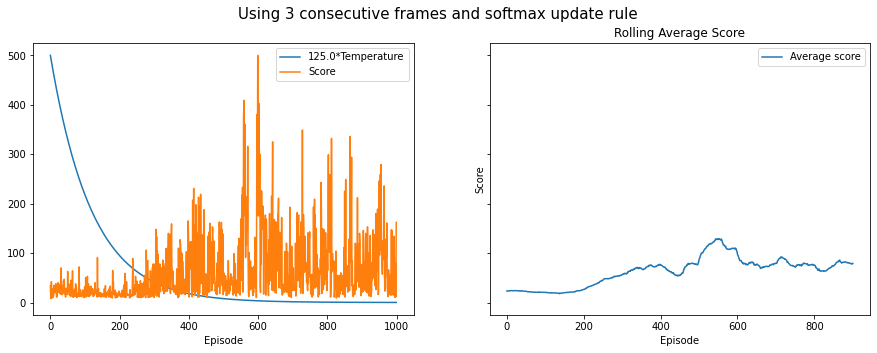

In [33]:
n_frames     = 2
update_type  = 'softmax'
scale        = 50
type_preproc = 2 

#initialize the exploration profile
my_profile_obj = exploration_profile(explor_type = 2, initial_temp = 4 , num_iterations = 1000)
my_profile     = my_profile_obj.get_profile()

start_time = time.time()
results5, net5 = training(my_profile,
                      n_frames = n_frames,
                      update_type = update_type,
                      preproc = (type_preproc, scale),
                      inter_channels  = 4)
end_time   = time.time()

# clear_output(wait = True)
print("Time taken for training was: ", end_time - start_time, "seconds")
plot_results(results5, my_profile, n_frames + 1, update_type)

EPISODE: 1 - FINAL SCORE: 13 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 19 - Temperature: 3.966866922953173
EPISODE: 3 - FINAL SCORE: 11 - Temperature: 3.934008296104994
EPISODE: 4 - FINAL SCORE: 30 - Temperature: 3.901421846110568
EPISODE: 5 - FINAL SCORE: 31 - Temperature: 3.869105318455729
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 3.8370564773010587
EPISODE: 7 - FINAL SCORE: 29 - Temperature: 3.8052731053271978
EPISODE: 8 - FINAL SCORE: 39 - Temperature: 3.773753003581442
EPISODE: 9 - FINAL SCORE: 17 - Temperature: 3.742493991325602
EPISODE: 10 - FINAL SCORE: 19 - Temperature: 3.7114939058851326
EPISODE: 11 - FINAL SCORE: 56 - Temperature: 3.6807506024995025
EPISODE: 12 - FINAL SCORE: 21 - Temperature: 3.6502619541738097
EPISODE: 13 - FINAL SCORE: 50 - Temperature: 3.620025851531624
EPISODE: 14 - FINAL SCORE: 28 - Temperature: 3.5900402026690483
EPISODE: 15 - FINAL SCORE: 16 - Temperature: 3.5603029330099885
EPISODE: 16 - FINAL SCORE: 22 - Temperature: 3.5308119851626225
EPISODE:

EPISODE: 130 - FINAL SCORE: 20 - Temperature: 1.3679353039025004
EPISODE: 131 - FINAL SCORE: 19 - Temperature: 1.3566043274476813
EPISODE: 132 - FINAL SCORE: 22 - Temperature: 1.3453672085218358
EPISODE: 133 - FINAL SCORE: 25 - Temperature: 1.3342231696777787
EPISODE: 134 - FINAL SCORE: 17 - Temperature: 1.3231714399081296
EPISODE: 135 - FINAL SCORE: 28 - Temperature: 1.3122112545919704
EPISODE: 136 - FINAL SCORE: 15 - Temperature: 1.3013418554419431
EPISODE: 137 - FINAL SCORE: 20 - Temperature: 1.2905624904517885
EPISODE: 138 - FINAL SCORE: 41 - Temperature: 1.2798724138443174
EPISODE: 139 - FINAL SCORE: 18 - Temperature: 1.2692708860198143
EPISODE: 140 - FINAL SCORE: 15 - Temperature: 1.258757173504867
EPISODE: 141 - FINAL SCORE: 27 - Temperature: 1.2483305489016214
EPISODE: 142 - FINAL SCORE: 20 - Temperature: 1.2379902908374552
EPISODE: 143 - FINAL SCORE: 15 - Temperature: 1.2277356839150697
EPISODE: 144 - FINAL SCORE: 12 - Temperature: 1.2175660186629955
EPISODE: 145 - FINAL SCORE

EPISODE: 257 - FINAL SCORE: 12 - Temperature: 0.47565913816590616
EPISODE: 258 - FINAL SCORE: 17 - Temperature: 0.4717191254476866
EPISODE: 259 - FINAL SCORE: 18 - Temperature: 0.4678117489157066
EPISODE: 260 - FINAL SCORE: 20 - Temperature: 0.46393673823564785
EPISODE: 261 - FINAL SCORE: 58 - Temperature: 0.460093825312444
EPISODE: 262 - FINAL SCORE: 13 - Temperature: 0.4562827442717324
EPISODE: 263 - FINAL SCORE: 81 - Temperature: 0.45250323144145915
EPISODE: 264 - FINAL SCORE: 13 - Temperature: 0.4487550253336371
EPISODE: 265 - FINAL SCORE: 41 - Temperature: 0.44503786662625455
EPISODE: 266 - FINAL SCORE: 75 - Temperature: 0.44135149814533375
EPISODE: 267 - FINAL SCORE: 22 - Temperature: 0.4376956648471383
EPISODE: 268 - FINAL SCORE: 20 - Temperature: 0.4340701138005277
EPISODE: 269 - FINAL SCORE: 99 - Temperature: 0.4304745941694582
EPISODE: 270 - FINAL SCORE: 61 - Temperature: 0.42690885719562865
EPISODE: 271 - FINAL SCORE: 11 - Temperature: 0.4233726561812698
EPISODE: 272 - FINAL

EPISODE: 383 - FINAL SCORE: 55 - Temperature: 0.16677789620972458
EPISODE: 384 - FINAL SCORE: 120 - Temperature: 0.16539642998851845
EPISODE: 385 - FINAL SCORE: 164 - Temperature: 0.16402640682399852
EPISODE: 386 - FINAL SCORE: 36 - Temperature: 0.16266773193024509
EPISODE: 387 - FINAL SCORE: 21 - Temperature: 0.16132031130647573
EPISODE: 388 - FINAL SCORE: 31 - Temperature: 0.15998405173054184
EPISODE: 389 - FINAL SCORE: 62 - Temperature: 0.15865886075247893
EPISODE: 390 - FINAL SCORE: 52 - Temperature: 0.15734464668811052
EPISODE: 391 - FINAL SCORE: 32 - Temperature: 0.1560413186127048
EPISODE: 392 - FINAL SCORE: 13 - Temperature: 0.15474878635468398
EPISODE: 393 - FINAL SCORE: 35 - Temperature: 0.1534669604893858
EPISODE: 394 - FINAL SCORE: 49 - Temperature: 0.1521957523328765
EPISODE: 395 - FINAL SCORE: 28 - Temperature: 0.15093507393581526
EPISODE: 396 - FINAL SCORE: 28 - Temperature: 0.1496848380773693
EPISODE: 397 - FINAL SCORE: 27 - Temperature: 0.14844495825917944
EPISODE: 398

EPISODE: 507 - FINAL SCORE: 120 - Temperature: 0.059457392270739075
EPISODE: 508 - FINAL SCORE: 24 - Temperature: 0.058964890680961626
EPISODE: 509 - FINAL SCORE: 29 - Temperature: 0.058476468614464115
EPISODE: 510 - FINAL SCORE: 122 - Temperature: 0.057992092279456765
EPISODE: 511 - FINAL SCORE: 52 - Temperature: 0.05751172816405628
EPISODE: 512 - FINAL SCORE: 26 - Temperature: 0.05703534303396732
EPISODE: 513 - FINAL SCORE: 42 - Temperature: 0.05656290393018316
EPISODE: 514 - FINAL SCORE: 32 - Temperature: 0.0560943781667054
EPISODE: 515 - FINAL SCORE: 24 - Temperature: 0.055629733328282575
EPISODE: 516 - FINAL SCORE: 66 - Temperature: 0.05516893726816747
EPISODE: 517 - FINAL SCORE: 70 - Temperature: 0.05471195810589303
EPISODE: 518 - FINAL SCORE: 49 - Temperature: 0.054258764225066695
EPISODE: 519 - FINAL SCORE: 33 - Temperature: 0.053809324271183005
EPISODE: 520 - FINAL SCORE: 76 - Temperature: 0.053363607149454304
EPISODE: 521 - FINAL SCORE: 23 - Temperature: 0.05292158202265944
E

EPISODE: 631 - FINAL SCORE: 62 - Temperature: 0.021196942616370597
EPISODE: 632 - FINAL SCORE: 17 - Temperature: 0.021021362633154253
EPISODE: 633 - FINAL SCORE: 88 - Temperature: 0.020847237026215854
EPISODE: 634 - FINAL SCORE: 85 - Temperature: 0.020674553748565087
EPISODE: 635 - FINAL SCORE: 36 - Temperature: 0.020503300853000093
EPISODE: 636 - FINAL SCORE: 13 - Temperature: 0.02033346649128091
EPISODE: 637 - FINAL SCORE: 20 - Temperature: 0.02016503891330974
EPISODE: 638 - FINAL SCORE: 17 - Temperature: 0.019998006466318
EPISODE: 639 - FINAL SCORE: 41 - Temperature: 0.019832357594060136
EPISODE: 640 - FINAL SCORE: 27 - Temperature: 0.019668080836014082
EPISODE: 641 - FINAL SCORE: 10 - Temperature: 0.019505164826588362
EPISODE: 642 - FINAL SCORE: 65 - Temperature: 0.019343598294335757
EPISODE: 643 - FINAL SCORE: 86 - Temperature: 0.019183370061173485
EPISODE: 644 - FINAL SCORE: 145 - Temperature: 0.019024469041609822
EPISODE: 645 - FINAL SCORE: 27 - Temperature: 0.01886688424197716


EPISODE: 754 - FINAL SCORE: 28 - Temperature: 0.0076199645431850125
EPISODE: 755 - FINAL SCORE: 48 - Temperature: 0.007556846325109152
EPISODE: 756 - FINAL SCORE: 10 - Temperature: 0.007494250932228934
EPISODE: 757 - FINAL SCORE: 132 - Temperature: 0.007432174033842485
EPISODE: 758 - FINAL SCORE: 12 - Temperature: 0.007370611335120303
EPISODE: 759 - FINAL SCORE: 34 - Temperature: 0.007309558576808113
EPISODE: 760 - FINAL SCORE: 34 - Temperature: 0.007249011534932194
EPISODE: 761 - FINAL SCORE: 15 - Temperature: 0.007188966020507132
EPISODE: 762 - FINAL SCORE: 14 - Temperature: 0.007129417879246011
EPISODE: 763 - FINAL SCORE: 15 - Temperature: 0.00707036299127299
EPISODE: 764 - FINAL SCORE: 63 - Temperature: 0.0070117972708382695
EPISODE: 765 - FINAL SCORE: 125 - Temperature: 0.006953716666035416
EPISODE: 766 - FINAL SCORE: 21 - Temperature: 0.006896117158521026
EPISODE: 767 - FINAL SCORE: 82 - Temperature: 0.0068389947632367205
EPISODE: 768 - FINAL SCORE: 48 - Temperature: 0.0067823455

EPISODE: 876 - FINAL SCORE: 14 - Temperature: 0.002762135864010082
EPISODE: 877 - FINAL SCORE: 36 - Temperature: 0.0027392563489110696
EPISODE: 878 - FINAL SCORE: 82 - Temperature: 0.0027165663509961992
EPISODE: 879 - FINAL SCORE: 23 - Temperature: 0.0026940643004436057
EPISODE: 880 - FINAL SCORE: 13 - Temperature: 0.0026717486404346795
EPISODE: 881 - FINAL SCORE: 19 - Temperature: 0.00264961782704636
EPISODE: 882 - FINAL SCORE: 25 - Temperature: 0.0026276703291443168
EPISODE: 883 - FINAL SCORE: 30 - Temperature: 0.002605904628277017
EPISODE: 884 - FINAL SCORE: 30 - Temperature: 0.0025843192185706705
EPISODE: 885 - FINAL SCORE: 63 - Temperature: 0.0025629126066250463
EPISODE: 886 - FINAL SCORE: 74 - Temperature: 0.0025416833114101484
EPISODE: 887 - FINAL SCORE: 12 - Temperature: 0.0025206298641637513
EPISODE: 888 - FINAL SCORE: 11 - Temperature: 0.002499750808289784
EPISODE: 889 - FINAL SCORE: 59 - Temperature: 0.0024790446992575504
EPISODE: 890 - FINAL SCORE: 22 - Temperature: 0.00245

EPISODE: 997 - FINAL SCORE: 12 - Temperature: 0.0010096003283672072
EPISODE: 998 - FINAL SCORE: 89 - Temperature: 0.001001237537000634
EPISODE: 999 - FINAL SCORE: 30 - Temperature: 0.0009929440168867296
EPISODE: 1000 - FINAL SCORE: 166 - Temperature: 0.000984719194233056

Time taken for training was:  6063.409379243851 seconds


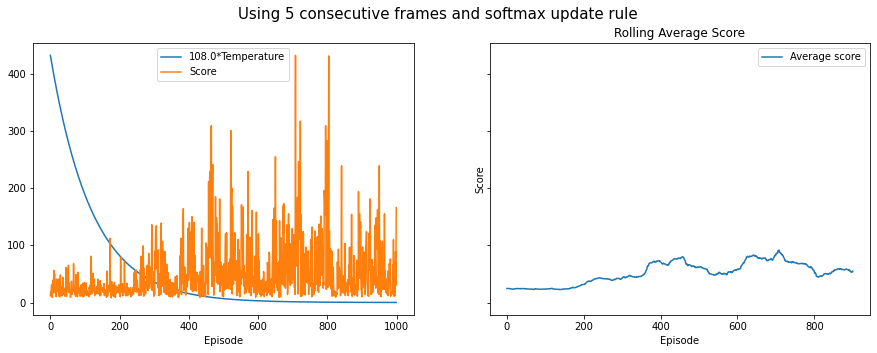

In [34]:
n_frames     = 4
update_type  = 'softmax'
scale        = 50
type_preproc = 2 

#initialize the exploration profile
my_profile_obj = exploration_profile(explor_type = 2, initial_temp = 4, num_iterations = 1000)
my_profile     = my_profile_obj.get_profile()

start_time = time.time()
results6, net6 = training(my_profile,
                      n_frames = n_frames,
                      update_type = update_type,
                      preproc = (type_preproc, scale),
                      inter_channels  = 4)
end_time   = time.time()

# clear_output(wait = True)
print("Time taken for training was: ", end_time - start_time, "seconds")
plot_results(results6, my_profile, n_frames + 1, update_type)

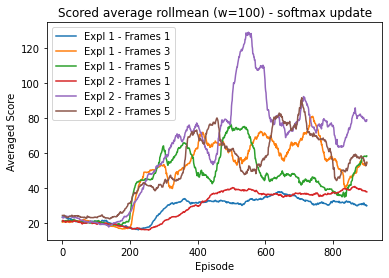

In [35]:
plt.plot(moving_average(results1, 100), label = "Expl 1 - Frames 1")
plt.plot(moving_average(results2, 100), label = "Expl 1 - Frames 3")
plt.plot(moving_average(results3, 100), label = "Expl 1 - Frames 5")
plt.plot(moving_average(results4, 100), label = "Expl 2 - Frames 1")
plt.plot(moving_average(results5, 100), label = "Expl 2 - Frames 3")
plt.plot(moving_average(results6, 100), label = "Expl 2 - Frames 5")
plt.legend()
plt.ylabel("Averaged Score")
plt.xlabel("Episode")
plt.title("Scored average rollmean (w=100) - softmax update")
plt.savefig('Results_pixel.png')
plt.show()

In [37]:
torch.save(net5.state_dict(), 'Cartpole_pixel.pth')

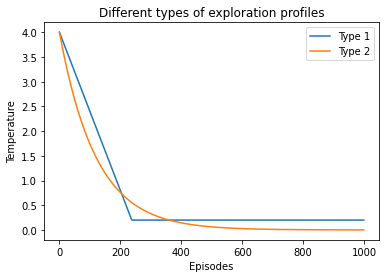

In [40]:
my_profile1 = exploration_profile(explor_type = 1, initial_temp = 4 , num_iterations = 1000).get_profile()
my_profile2 = exploration_profile(explor_type = 2, initial_temp = 4 , num_iterations = 1000).get_profile()

plt.plot(my_profile1, label = "Type 1")
plt.plot(my_profile2, label = "Type 2")
plt.title("Different types of exploration profiles")
plt.xlabel("Episodes")
plt.ylabel("Temperature")
plt.legend()
plt.show()

In [39]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(seed+1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, folder = 'pixel' , video_callable=lambda episode_id: True) # Save a video every episode
env.reset()

type_preproc = 2
scale        = 50
n_frames     = 2
update_type  = 'softmax' 

frame = preprocess_frame(env, type_preproc, scale)

frame_history = deque(maxlen=n_frames)
for i in range(n_frames): 
    frame_history.append(np.zeros((1, frame.shape[0], frame.shape[1])))
    
scores = []

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    frame = preprocess_frame(env, type_preproc, scale)[np.newaxis, :]
    
    for i in range(n_frames):
        frame = np.append( frame , frame_history[-i-1], axis=0)
   
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        for i in range(n_frames):
            if frame_history[i] is None: 
                frame_history[i] = np.zeros((1, frame.shape[0], frame.shape[1]))

        frame_history.append(frame[0][np.newaxis, :])
        # Choose the action following the policy
        if update_type == 'softmax':
            action, q_values = choose_action_softmax(net5, convert_frame_to_tensor(frame), temperature=0)
        elif update_type == 'greedy': 
            action, q_values = choose_action_epsilon_greedy(net5, convert_frame_to_tensor(frame), 0)
        else:
            print("Not valid update rule")
            break
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        next_frame = preprocess_frame(env, type_preproc, scale)[np.newaxis, :]
        for i in range(n_frames):
            next_frame = np.append( next_frame, frame_history[-i-1], axis=0) 
        # Visually render the environment
        env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        frame = next_frame
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    scores.append(score)
    
env.close() 

print("Max score obtained is \t \t:", max(scores))

EPISODE 1 - FINAL SCORE: 158.0
EPISODE 2 - FINAL SCORE: 183.0
EPISODE 3 - FINAL SCORE: 191.0
EPISODE 4 - FINAL SCORE: 163.0
EPISODE 5 - FINAL SCORE: 164.0
EPISODE 6 - FINAL SCORE: 168.0
EPISODE 7 - FINAL SCORE: 190.0
EPISODE 8 - FINAL SCORE: 172.0
EPISODE 9 - FINAL SCORE: 172.0
EPISODE 10 - FINAL SCORE: 161.0
Max score obtained is 	 	: 191.0


In [42]:
print("Average score obtained is:", np.mean(scores))

Average score obtained is: 172.2


One can see as network is able to learn something.

# No need to run, it takes ages running hyperparams optimization :)

Let us compare parameters using Optuna, and using as metric the score obtained by averaging the last 100 episode scores

In [ ]:
def objective(trial):
    
    n_frames     = trial.suggest_int("n_frames", 0, 4)
    upd_type     = trial.suggest_categorical("upd_type", ['greedy', 'softmax'])
    scale        = trial.suggest_categorical("scale"   , [50, 75, 100])
    type_preproc = trial.suggest_categorical("preproc" , [0, 1, 2])
    explor_type  = trial.suggest_categorical("explor_type" , [0, 1, 2])
        
    if upd_type == 'greedy':
        initial_temp = 1.
    elif upd_type == 'softmax':
        initial_temp = 4.
    
    #initialize the exploration profile
    my_profile_obj = exploration_profile(explor_type = explor_type, initial_temp = initial_temp , num_iterations = 1000)
    my_profile     = my_profile_obj.get_profile()
    
    start_time = time.time()
    results, _ = training(my_profile, 
                       n_frames       = n_frames, 
                       update_type    = upd_type, 
                       preproc        = (type_preproc, scale),
                       inter_channels = 4,
                       optuna_flag    = True
                      )
    end_time   = time.time()
    
    results_av = moving_average(results, 100)
    
    return np.mean(results_av)

In [ ]:
study = optuna.create_study(direction="maximize")

In [ ]:
study.optimize(objective, n_trials = 10)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

In [ ]:
trials_df = study.trials_dataframe()
trials_df.to_csv('optuna_pixels.csv')

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
fine_opt_network_dictionary = {}
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value)) 
    fine_opt_network_dictionary.update({key:value})
trials_df

trials_df

In [ ]:
if fine_opt_network_dictionary.get('upd_type') == 'greedy':
    initial_temp = 1.
elif fine_opt_network_dictionary.get('upd_type') == 'softmax':
    initial_temp = 4.

#initialize the exploration profile
my_profile = exploration_profile(explor_type = fine_opt_network_dictionary.get('explor_type'),
                                 initial_temp = initial_temp, 
                                 num_iterations = 1000).get_profile()

start_time = time.time()    
best_network_results,  policy_net = training(my_profile, 
                       n_frames       = fine_opt_network_dictionary.get('n_frames'), 
                       update_type    = fine_opt_network_dictionary.get('upd_type'), 
                       preproc        = (fine_opt_network_dictionary.get('preproc'), fine_opt_network_dictionary.get('scale')),
                       inter_channels = 4)
end_time   = time.time()

clear_output(wait = True)
print("Time taken for training was: ", end_time - start_time, "seconds")
plot_results(best_network_results, my_profile, n_frames + 1, update_type)

In [ ]:
torch.save(policy_net.state_dict(), 'Cartpole_Pixels.pth')

# Final test

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(seed+1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, folder = 'pixel' , video_callable=lambda episode_id: True) # Save a video every episode
env.reset()

type_preproc = fine_opt_network_dictionary.get('preproc')
scale        = fine_opt_network_dictionary.get('scale') 
n_frames     = fine_opt_network_dictionary.get('n_frames') 
update_type  = fine_opt_network_dictionary.get('upd_type') 

frame = preprocess_frame(env, type_preproc, scale)

frame_history = deque(maxlen=n_frames)
for i in range(n_frames): 
    frame_history.append(np.zeros((1, frame.shape[0], frame.shape[1])))
    
scores = []

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    frame = preprocess_frame(env, type_preproc, scale)[np.newaxis, :]
    
    for i in range(n_frames):
        frame = np.append( frame , frame_history[-i-1], axis=0)
   
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        for i in range(n_frames):
            if frame_history[i] is None: 
                frame_history[i] = np.zeros((1, frame.shape[0], frame.shape[1]))

        frame_history.append(frame[0][np.newaxis, :])
        # Choose the action following the policy
        if update_type == 'softmax':
            action, q_values = choose_action_softmax(policy_net, convert_frame_to_tensor(frame), temperature=0)
        elif update_type == 'greedy': 
            action, q_values = choose_action_epsilon_greedy(policy_net, convert_frame_to_tensor(frame), 0)
        else:
            print("Not valid update rule")
            break
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        next_frame = preprocess_frame(env, type_preproc, scale)[np.newaxis, :]
        for i in range(n_frames):
            next_frame = np.append( next_frame, frame_history[-i-1], axis=0) 
        # Visually render the environment
        env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        frame = next_frame
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    scores.append(score)
    
env.close() 

print("Max score obtained is \t \t:", max(scores))